In [1]:
# ignore all the votable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors, patches
import pandas as pd
import numpy as np
import palettable

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia

import kinesis

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
plt.rc("figure", dpi=120)
plt.rc('axes', labelsize=15)

Reino et al. performed a kinematic modolling of the Hyades cluster using TGAS+Hipparcos data.

- 251 candidate members, 64 outliers removed leaving 187 members through an iterative process

In [4]:
reino = pd.read_csv(
    "data/Reino2018_supp.txt", comment='#', delim_whitespace=True,
    dtype={'HIP':str, 'TYC':str, 'source_id':str})
print(len(reino), "rows")

251 rows


In [6]:
reino = reino.reset_index()  # keep row index
# Query full tgas table for tgas sources only
reino_tgas = reino.loc[reino.source_id.notnull()]
try:
    hy_tgas = pd.read_csv("data/reino_tgas_full.csv")
    print("Read table from the local file")
except FileNotFoundError:
    r = Gaia.launch_job("""select * from TAP_UPLOAD.reino left join gaiadr1.tgas_source tgas on tgas.source_id = reino.source_id""",
        upload_resource=Table.from_pandas(reino_tgas[['index','source_id']].astype(int)),
        upload_table_name='reino').get_results()
    hy_tgas = r.to_pandas()
    hy_tgas.to_csv("data/reino_tgas_full.csv")

Read table from the local file


In [7]:
# full DR2 table for Hyades stars from DR2 van Leeuwen 2018
hy_dr2 = pd.read_csv("/Users/semyeong/projects/spelunky/oh17-dr2/dr2_vL_clusters_full.csv")\
    .groupby('cluster').get_group('Hyades')

In [8]:
hy_tgas = hy_tgas.pipe(kinesis.add_vtan).pipe(kinesis.add_vtan_errors)
hy_dr2 = hy_dr2.pipe(kinesis.add_vtan).pipe(kinesis.add_vtan_errors)

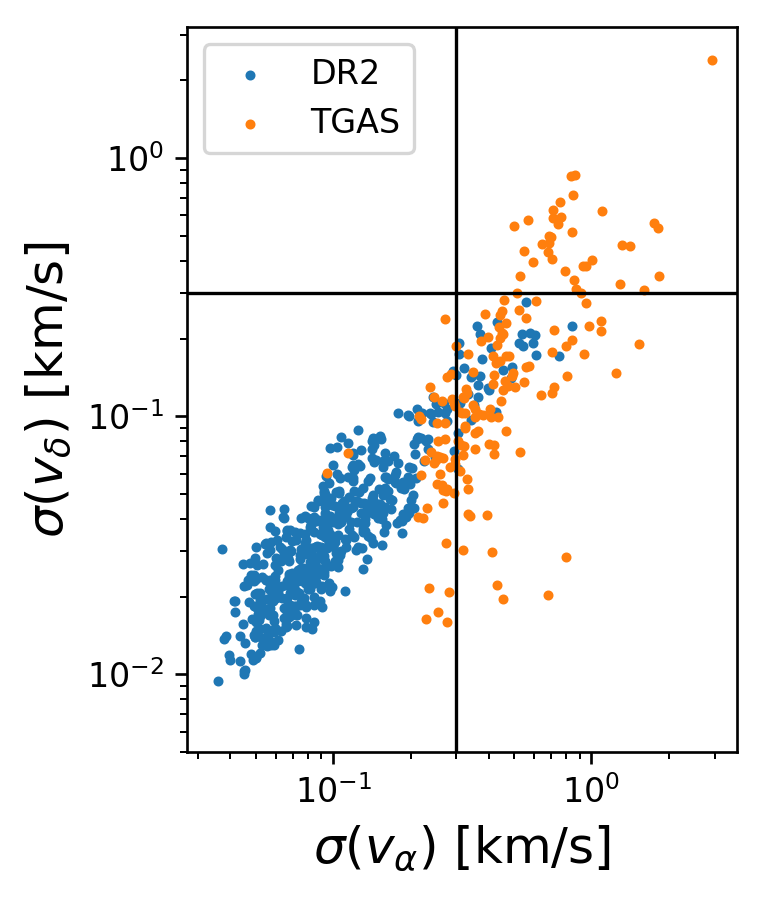

In [10]:
plt.axes(aspect='equal')
plt.scatter(hy_dr2.vra_error, hy_dr2.vdec_error, s=4, label='DR2')
plt.scatter(hy_tgas.vra_error, hy_tgas.vdec_error, s=4, label='TGAS')
plt.loglog();
plt.xlabel(r"$\sigma(v_\alpha)$ [km/s]")
plt.ylabel(r"$\sigma(v_\delta)$ [km/s]");
plt.axvline(0.3, c='k', lw=1)
plt.axhline(0.3, c='k', lw=1);
plt.legend(loc='upper left');

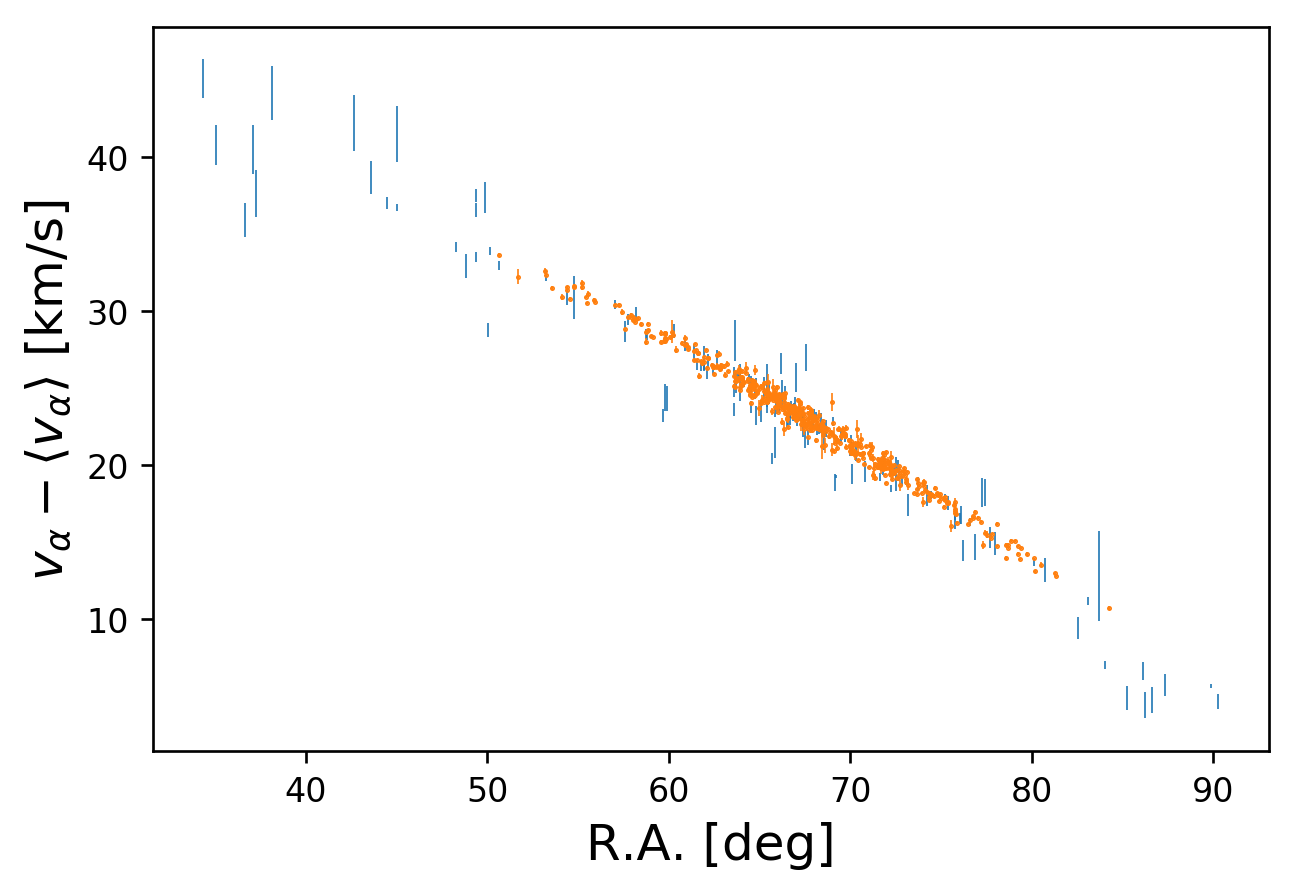

In [10]:
plt.errorbar(hy_tgas.ra, hy_tgas.vra,
             yerr=hy_tgas.vra_error, marker='None', ls='None', elinewidth=0.5)
plt.errorbar(hy_dr2.ra, hy_dr2.vra,
             yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=0.5, ls='None')
# plt.axhline(0, c='k', lw=1)
plt.xlabel("R.A. [deg]")
plt.ylabel(r"$v_\alpha - \langle v_\alpha \rangle$ [km/s]");

In [19]:
def project_mean_velocity(vmean, position):
    """
    Project vmean at `position` and get predicted proper motions
    
    vmean : quantity (v_x, v_y, v_z)
        in cartesian equatorial coordinates, km/s
    position :
    
    Returns (pmra, pmdec) in units of mas/yr
    """
    if isinstance(position, pd.DataFrame):
        icrs = kinesis.make_icrs(position, include_pm_rv=False)
    cartesian_coords = coord.ICRS(
        icrs.cartesian.xyz,
        v_x=[vmean[0]]*len(icrs),
        v_y=[vmean[1]]*len(icrs),
        v_z=[vmean[2]]*len(icrs),
        representation_type='cartesian',
        differential_type='cartesian')
    pmra = cartesian_coords.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
    pmdec = cartesian_coords.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value
    rv = cartesian_coords.spherical.differentials['s'].d_distance.to(u.km/u.s).value
    return pmra, pmdec, rv


vmean = [-5.96, 45.60, 5.57] * u.km/u.s   # cartesian equatorial
# vmean = [-6.14, 45.740104, 5.510726] * u.km/u.s
# vmean = [5.96, 35.60, -2.32] * u.km/u.s   # cartesian equatorial
pmra0_dr2, pmdec0_dr2, rv0_dr2 = project_mean_velocity(vmean, hy_dr2)
pmra0_tgas, pmdec0_tgas, rv0_tgas = project_mean_velocity(vmean, hy_tgas)

hy_tgas['dpmra'], hy_tgas['dpmdec'] = hy_tgas.pmra - pmra0_tgas, hy_tgas.pmdec - pmdec0_tgas
hy_dr2['dpmra'], hy_dr2['dpmdec'] = hy_dr2.pmra - pmra0_dr2, hy_dr2.pmdec - pmdec0_dr2

In [249]:
mockhy = kinesis.Cluster(vmean.value - np.r_[0, 0, 0], 0.3, omegas=[0,0.,0],
                         ws=[0,0,0,0,0],
                         b0=[17.2, 41.6, 13.6])
mockhy_members = mockhy.sample_at(kinesis.make_icrs(hy_dr2, coord.ICRS))
mockhy_members_pmra = mockhy_members.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
mockhy_members_pmdec = mockhy_members.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value
mockhy_members_dpmra = mockhy_members_pmra-pmra0_dr2
mockhy_members_dpmdec = mockhy_members_pmdec-pmdec0_dr2

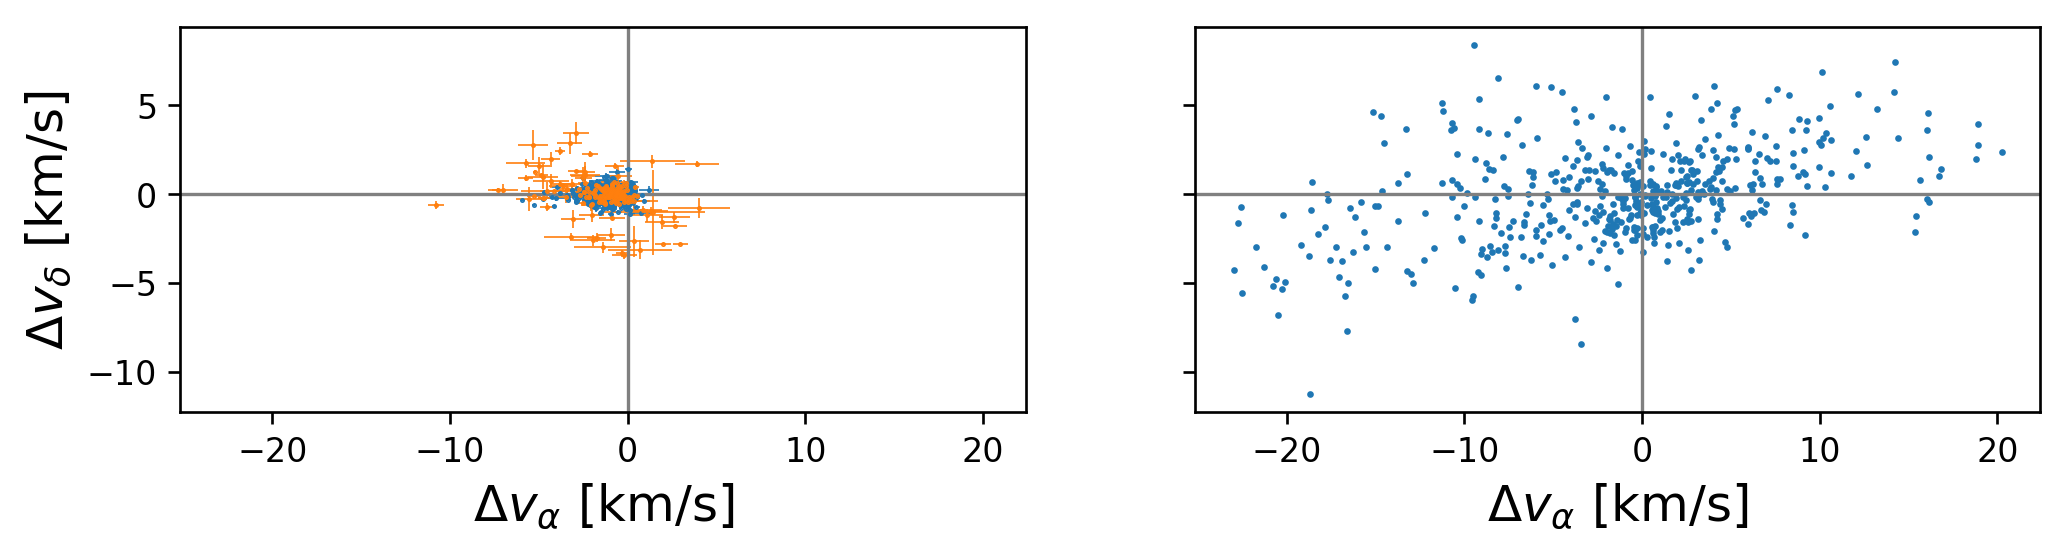

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2.dpmra/hy_dr2.parallax*4.74,
    hy_dr2.dpmdec/hy_dr2.parallax*4.74,
    ls='None',
    xerr=hy_dr2.vra_error, yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[0].errorbar(
    hy_tgas.dpmra/hy_tgas.parallax*4.74,
    hy_tgas.dpmdec/hy_tgas.parallax*4.74,
    ls='None',
    xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);


# for cax in ax: cax.axhline(0, c='k', lw=.5)
# for cax in ax: cax.axvline(0, c='k', lw=.5)
ax[1].scatter(mockhy_members_dpmra/hy_dr2.parallax*4.74,
              mockhy_members_dpmdec/hy_dr2.parallax*4.74, s=1)
# ax[0].set_xlim(-20,20)
ax[0].set_xlabel(r'$\Delta v_\alpha$ [km/s]')
ax[0].set_ylabel(r'$\Delta v_\delta$ [km/s]')
ax[1].set_xlabel(r'$\Delta v_\alpha$ [km/s]')
for cax in ax: cax.axvline(0, c='gray', lw=1);
for cax in ax: cax.axhline(0, c='gray', lw=1);
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

In [324]:
hy_dr2_rv = hy_dr2.loc[hy_dr2.radial_velocity_error<1]
hy_dr2_rv = kinesis.add_xv(hy_dr2_rv, coord.ICRS)

In [325]:
hy_dr2_rv[['vx','vy','vz']].describe()

vx          vy          vz
count  139.000000  139.000000  139.000000
mean    -6.135623   45.745833    5.546658
std      0.448765    0.743456    0.390913
min     -7.479896   43.153784    4.010967
25%     -6.447426   45.400936    5.322009
50%     -6.097717   45.722046    5.519079
75%     -5.842375   46.023831    5.737417
max     -4.672848   50.274383    7.074267

In [326]:
def get_slope(x, y):
    A = np.vander(x, 2)
    ATA = np.dot(A.T, A/1.)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y))
    sigma_w = np.linalg.inv(ATA)
    return mean_w[0], np.sqrt(sigma_w[0,0])

In [327]:
get_slope(hy_dr2_rv.x, hy_dr2_rv.vx),\
get_slope(hy_dr2_rv.x, hy_dr2_rv.vy),\
get_slope(hy_dr2_rv.x, hy_dr2_rv.vz)

((-0.003712283917980469, 0.02634943464097746),
 (-0.009614712793445597, 0.02634943464097746),
 (0.006178727441755854, 0.02634943464097746))

In [328]:
get_slope(hy_dr2_rv.y, hy_dr2_rv.vx),\
get_slope(hy_dr2_rv.y, hy_dr2_rv.vy),\
get_slope(hy_dr2_rv.y, hy_dr2_rv.vz)

((0.005524897445715989, 0.016053464904281296),
 (0.019552538704153234, 0.016053464904281296),
 (0.013933561791149001, 0.016053464904281296))

In [329]:
get_slope(hy_dr2_rv.z, hy_dr2_rv.vx),\
get_slope(hy_dr2_rv.z, hy_dr2_rv.vy),\
get_slope(hy_dr2_rv.z, hy_dr2_rv.vz)

((-2.849399892118473e-05, 0.02034109229504264),
 (0.018121903980713085, 0.02034109229504264),
 (0.006891594720183075, 0.02034109229504264))

In [330]:
1./(0.01*u.km/u.s/u.pc).to(1/u.Myr)

<Quantity 97.77922217 Myr>

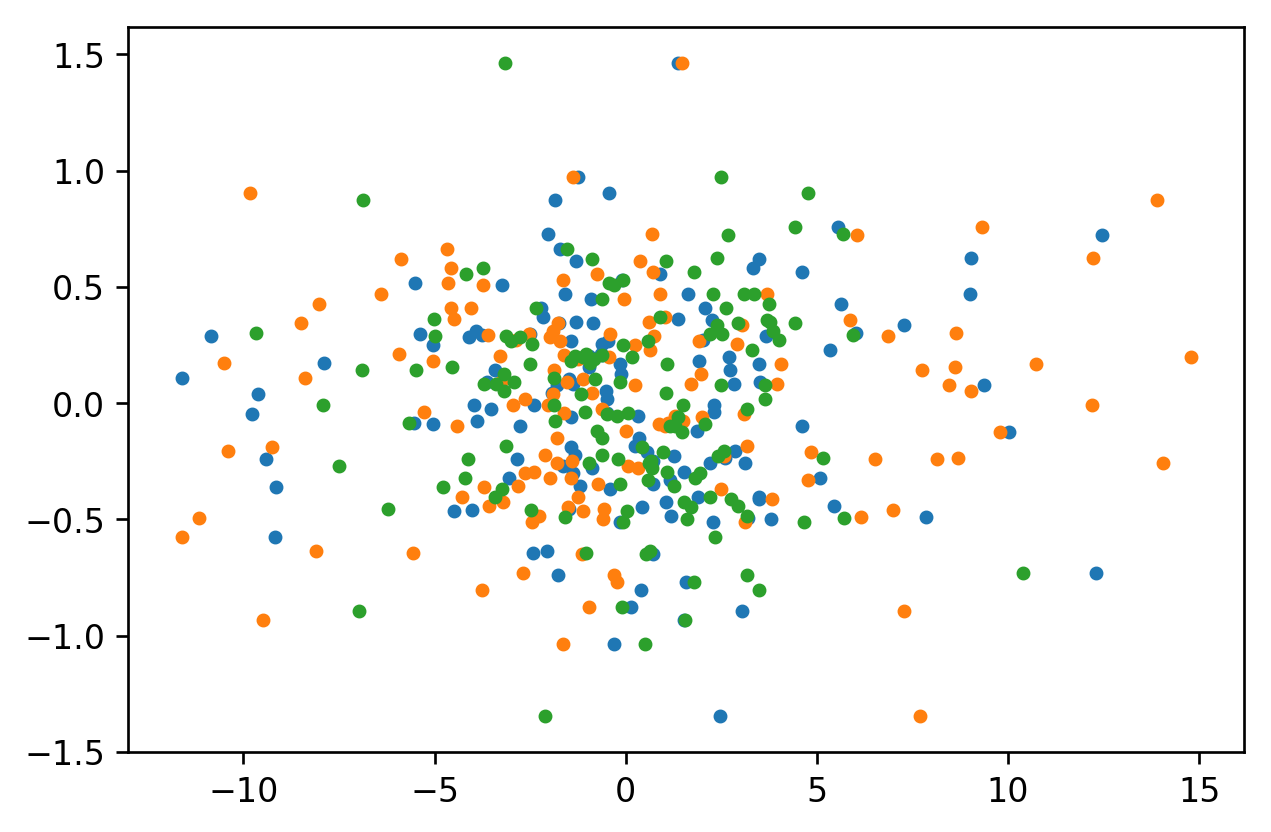

In [335]:
plt.scatter(hy_dr2_rv.z-hy_dr2_rv.z.mean(), hy_dr2_rv.vx-hy_dr2_rv.vx.mean(), s=10)
plt.scatter(hy_dr2_rv.y-hy_dr2_rv.y.mean(), hy_dr2_rv.vx-hy_dr2_rv.vx.mean(), s=10)
plt.scatter(hy_dr2_rv.x-hy_dr2_rv.x.mean(), hy_dr2_rv.vx-hy_dr2_rv.vx.mean(), s=10)
# plt.scatter(mockhy_members.cartesian.y,
#             mockhy_members.cartesian.differentials['s'].d_y, s=2)
# x=np.r_[30:55:1]
# plt.plot(x, 0.0195*x+44.9, c='k')
# plt.grid();

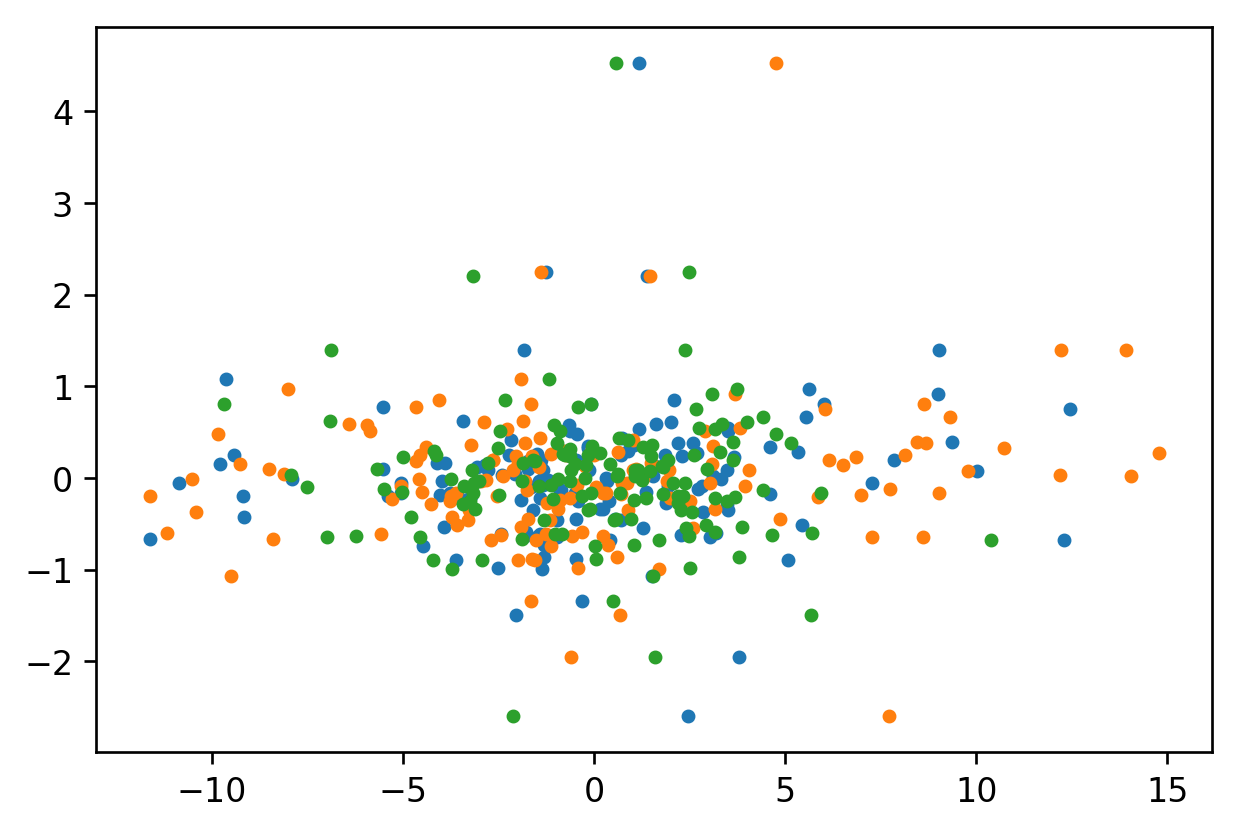

In [336]:
plt.scatter(hy_dr2_rv.z-hy_dr2_rv.z.mean(), hy_dr2_rv.vy-hy_dr2_rv.vy.mean(), s=10)
plt.scatter(hy_dr2_rv.y-hy_dr2_rv.y.mean(), hy_dr2_rv.vy-hy_dr2_rv.vy.mean(), s=10)
plt.scatter(hy_dr2_rv.x-hy_dr2_rv.x.mean(), hy_dr2_rv.vy-hy_dr2_rv.vy.mean(), s=10)

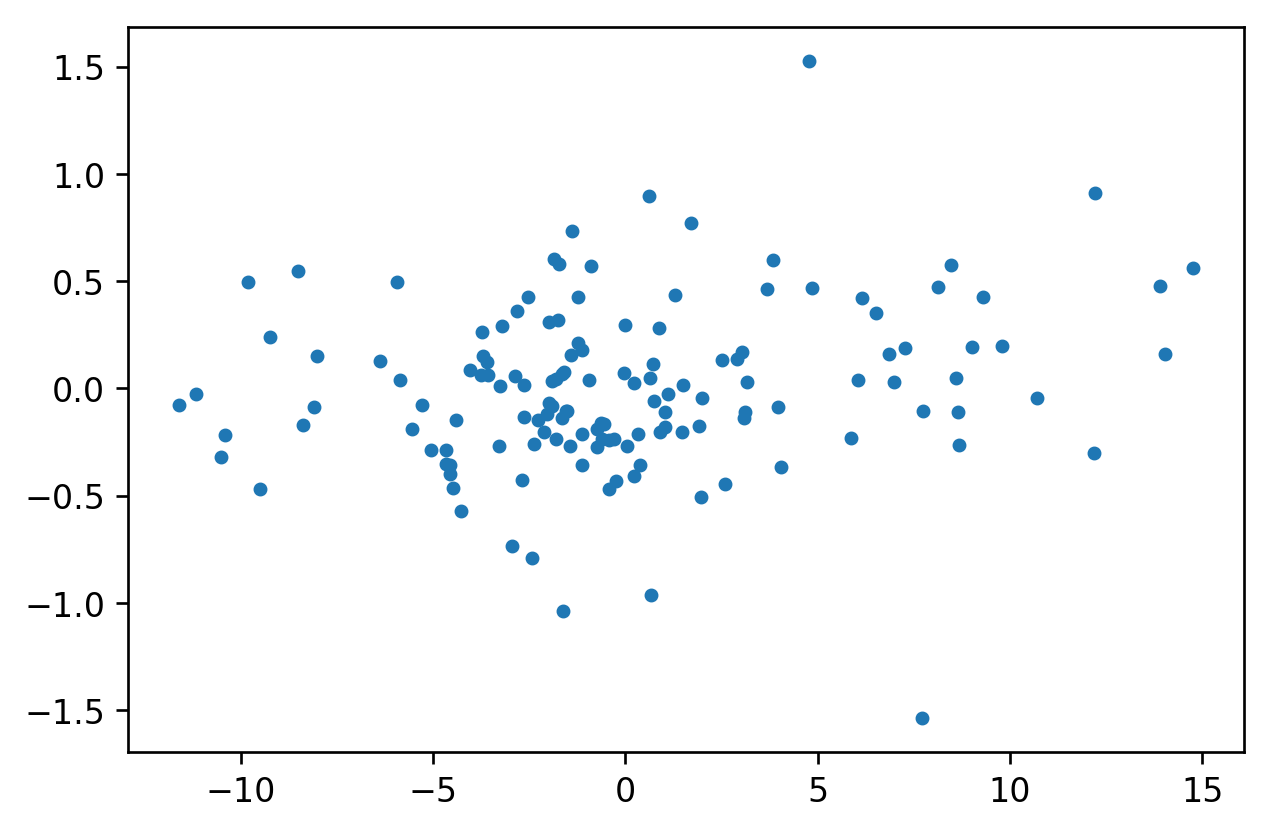

In [339]:
# plt.scatter(hy_dr2_rv.z-hy_dr2_rv.z.mean(), hy_dr2_rv.vz-hy_dr2_rv.vz.mean(), s=10)
plt.scatter(hy_dr2_rv.y-hy_dr2_rv.y.mean(), hy_dr2_rv.vz-hy_dr2_rv.vz.mean(), s=10)
# plt.scatter(hy_dr2_rv.x-hy_dr2_rv.x.mean(), hy_dr2_rv.vz-hy_dr2_rv.vz.mean(), s=10)

In [196]:
1./(20*u.km/u.s/u.pc).to(1/u.Myr)

<Quantity 0.04888961 Myr>

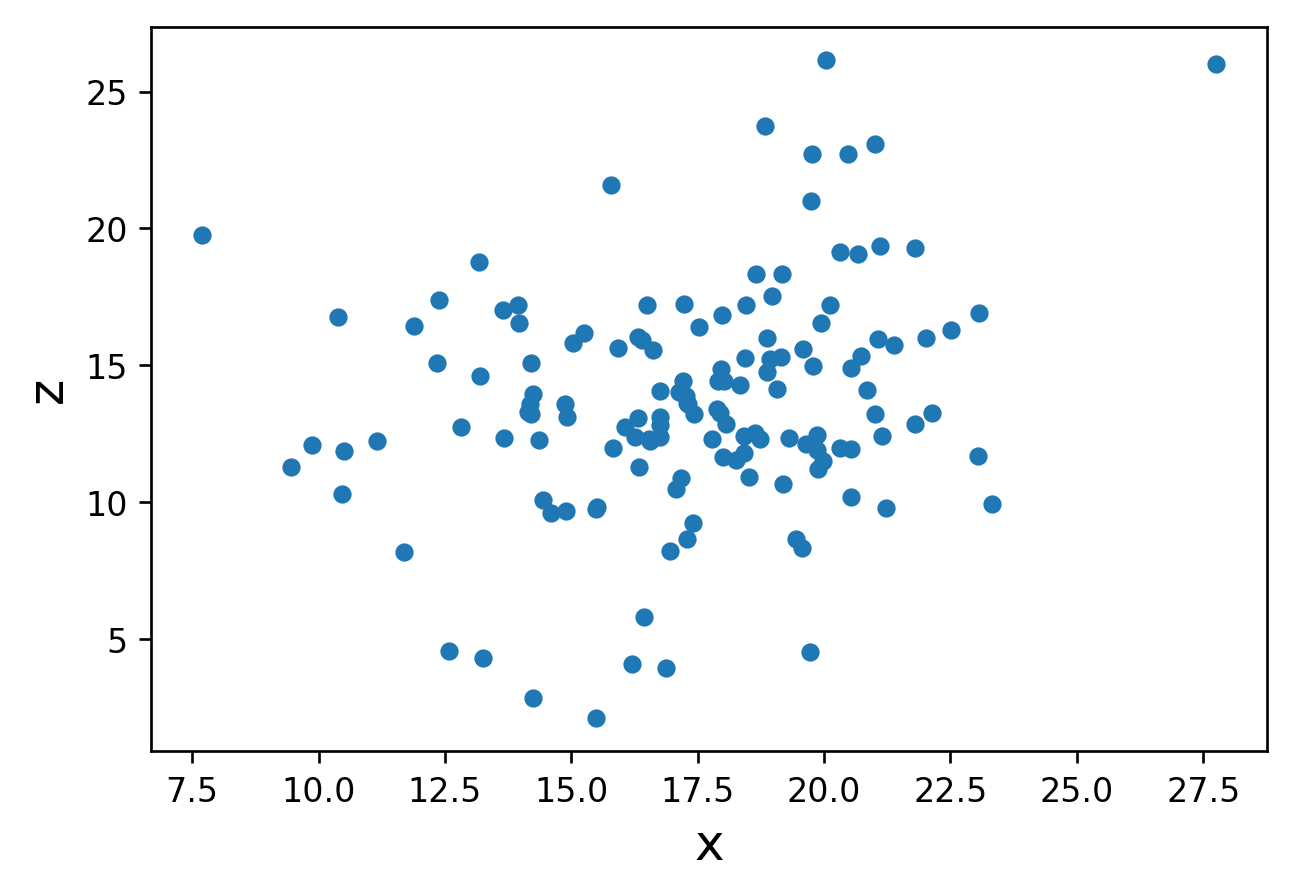

In [270]:
hy_dr2_rv.plot.scatter('x','z')

In [271]:
yslc = np.fabs(hy_dr2_rv.z-14)<1
yslc.sum()

29

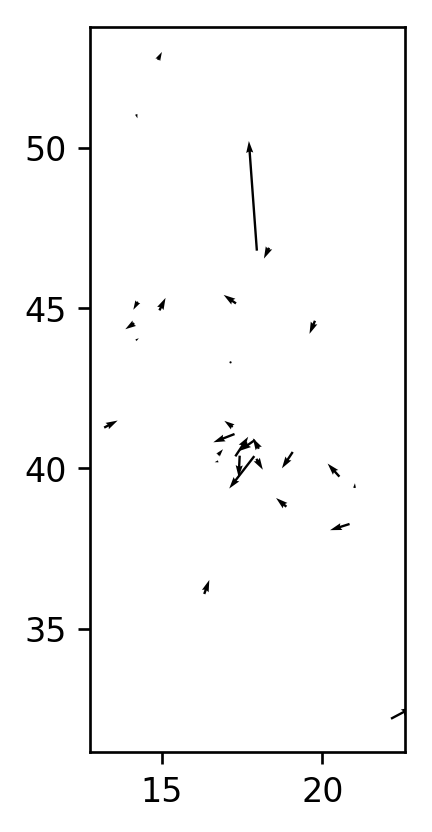

In [272]:
plt.axes(aspect='equal')
plt.quiver(hy_dr2_rv.x[yslc], hy_dr2_rv.y[yslc],
           hy_dr2_rv.vx[yslc]-hy_dr2_rv.vx.mean(), hy_dr2_rv.vy[yslc]-hy_dr2_rv.vy.mean());

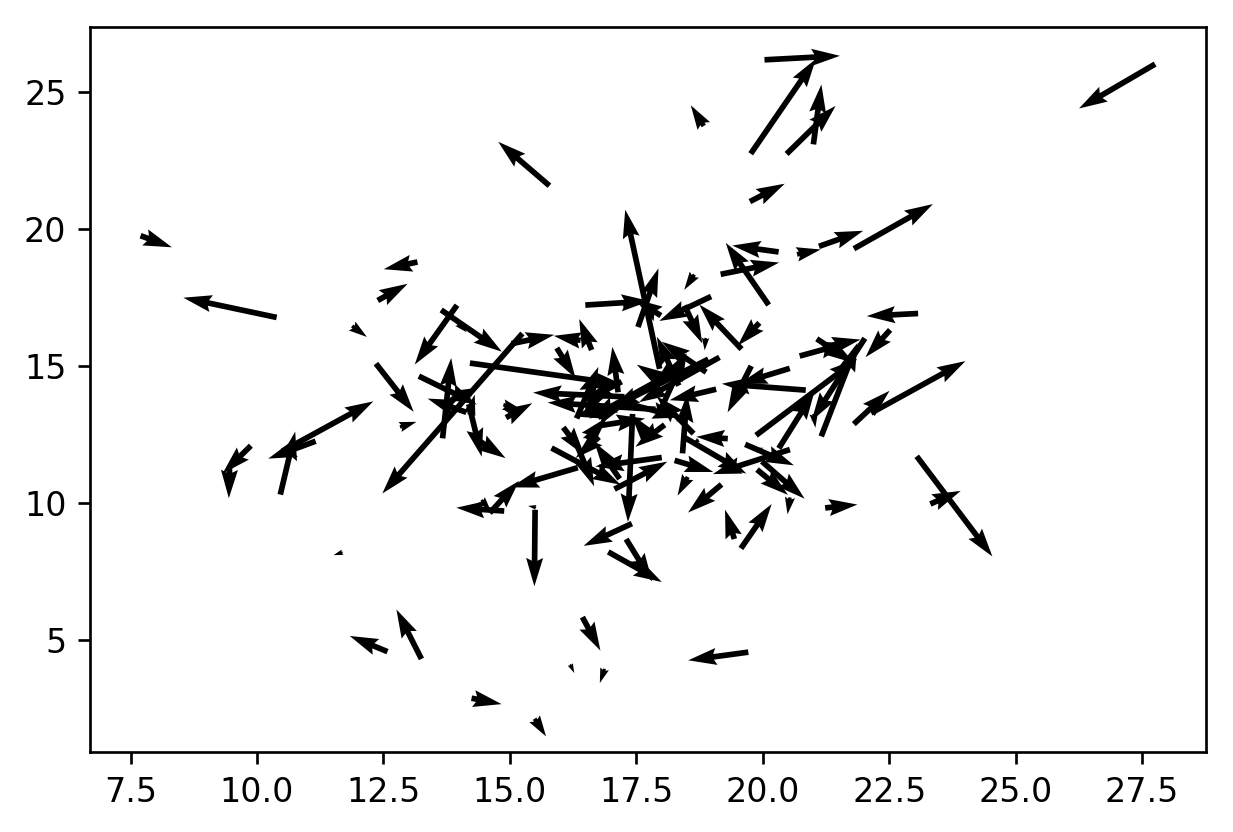

In [151]:
plt.quiver(hy_dr2_rv.x, hy_dr2_rv.z,
           hy_dr2_rv.vx-hy_dr2_rv.vx.mean(), hy_dr2_rv.vz-hy_dr2_rv.vz.mean());

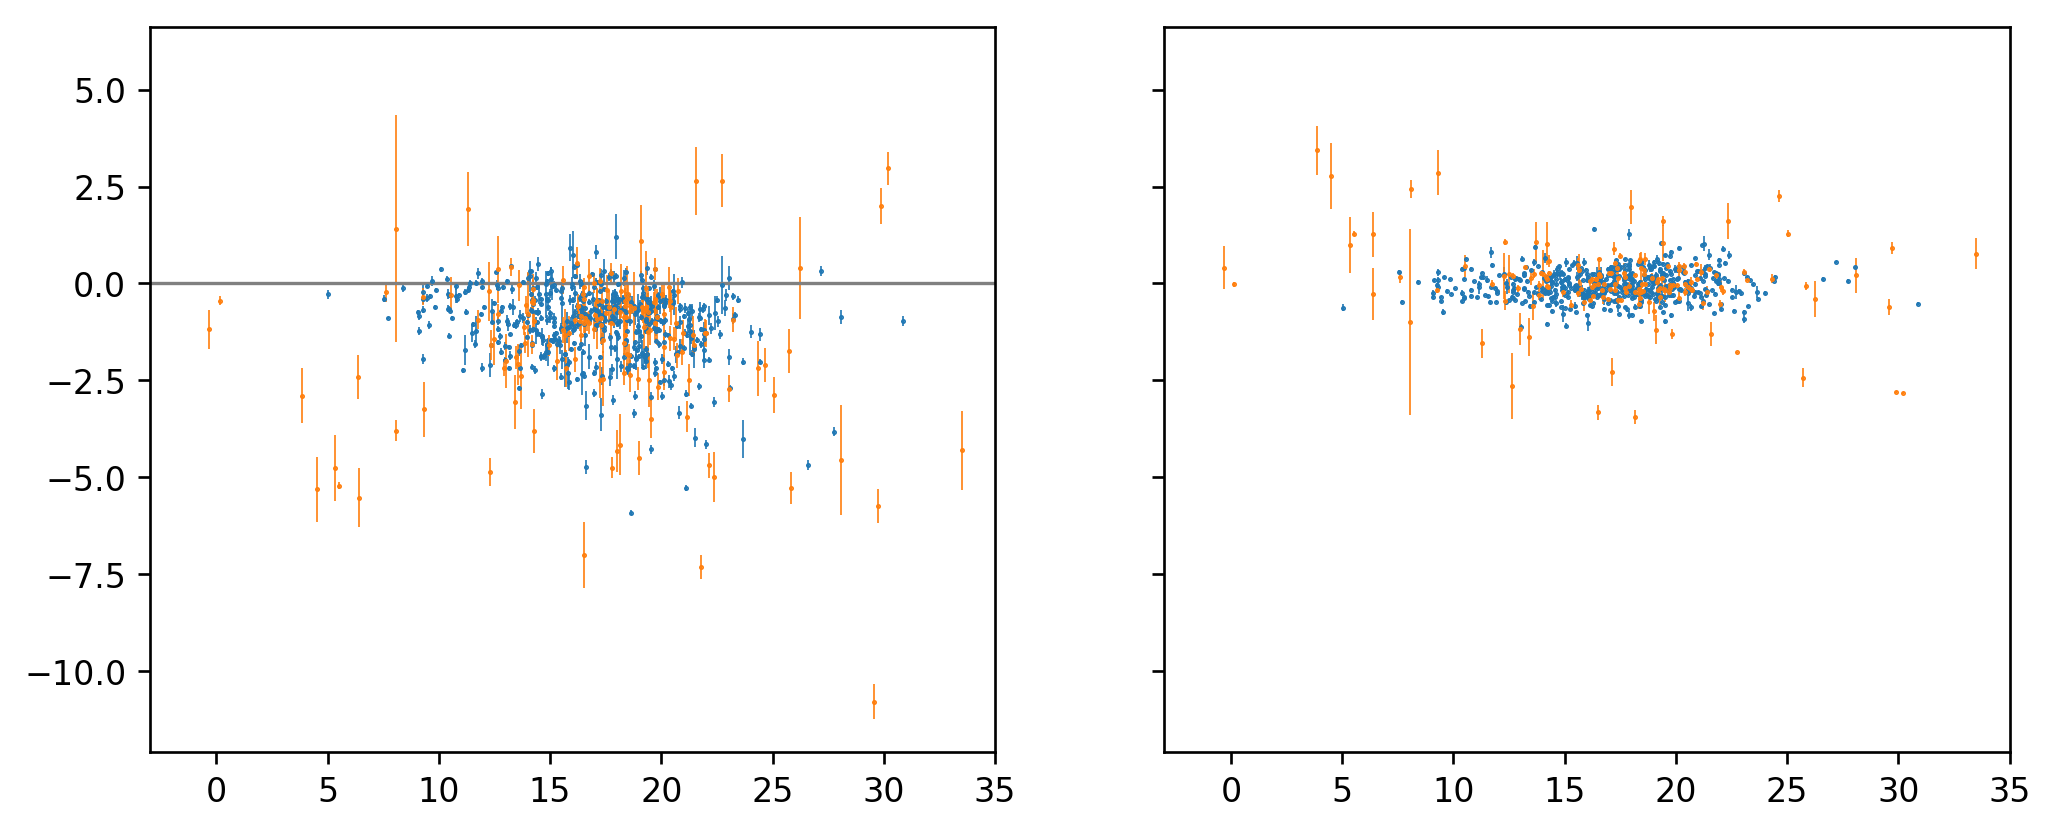

In [213]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2_coords.cartesian.x.value,
    hy_dr2.dpmra/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[0].errorbar(
    hy_tgas_coords.cartesian.x.value,
    hy_tgas.dpmra/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

ax[1].errorbar(
    hy_dr2_coords.cartesian.x.value,
    hy_dr2.dpmdec/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas_coords.cartesian.x.value,
    hy_tgas.dpmdec/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);


# for cax in ax: cax.axhline(0, c='k', lw=.5)
# for cax in ax: cax.axvline(0, c='k', lw=.5)
# ax[1].scatter(mockhy_members.spherical.lat.deg, mockhy_members_dpmra/hy_dr2.parallax*4.74, s=1)
# ax[0].set_ylim(-25,15)

plt.xlim(-3,35);

ax[0].axhline(0, lw=1, c='gray');

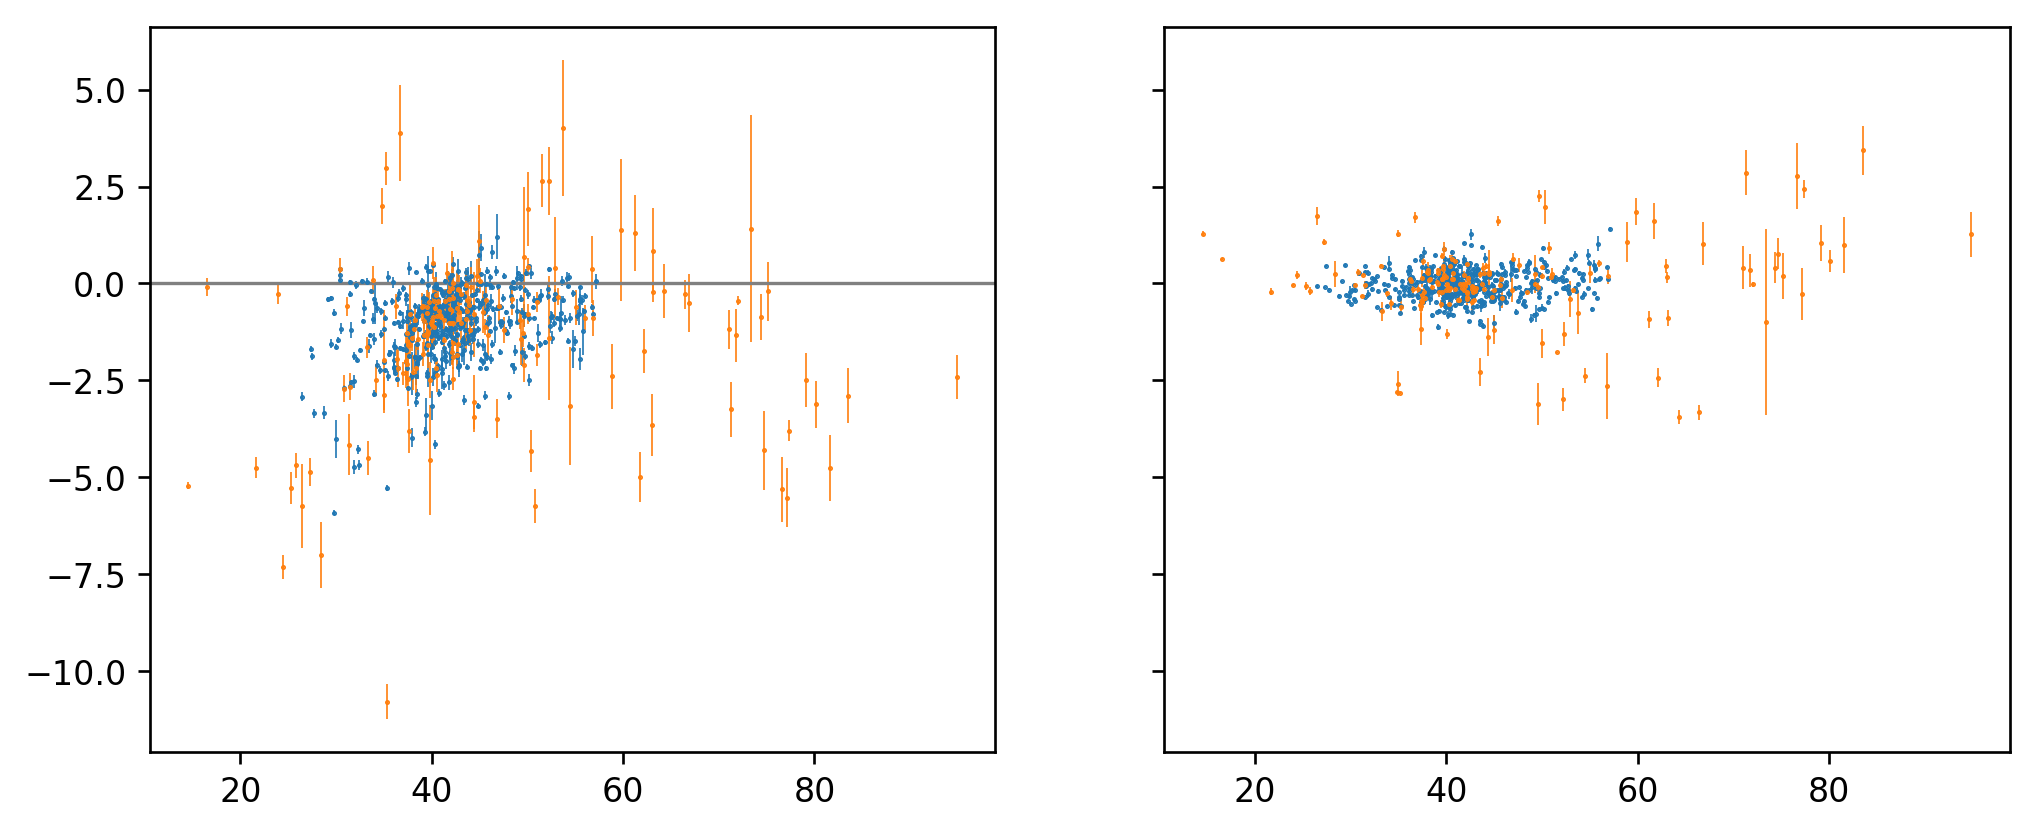

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2_coords.cartesian.y.value,
    hy_dr2.dpmra/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[0].errorbar(
    hy_tgas_coords.cartesian.y.value,
    hy_tgas.dpmra/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

ax[1].errorbar(
    hy_dr2_coords.cartesian.y.value,
    hy_dr2.dpmdec/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas_coords.cartesian.y.value,
    hy_tgas.dpmdec/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);


# for cax in ax: cax.axhline(0, c='k', lw=.5)
# for cax in ax: cax.axvline(0, c='k', lw=.5)
# ax[1].scatter(mockhy_members.spherical.lat.deg, mockhy_members_dpmra/hy_dr2.parallax*4.74, s=1)
# ax[0].set_ylim(-25,15)

# plt.xlim(-3,35);

ax[0].axhline(0, lw=1, c='gray');

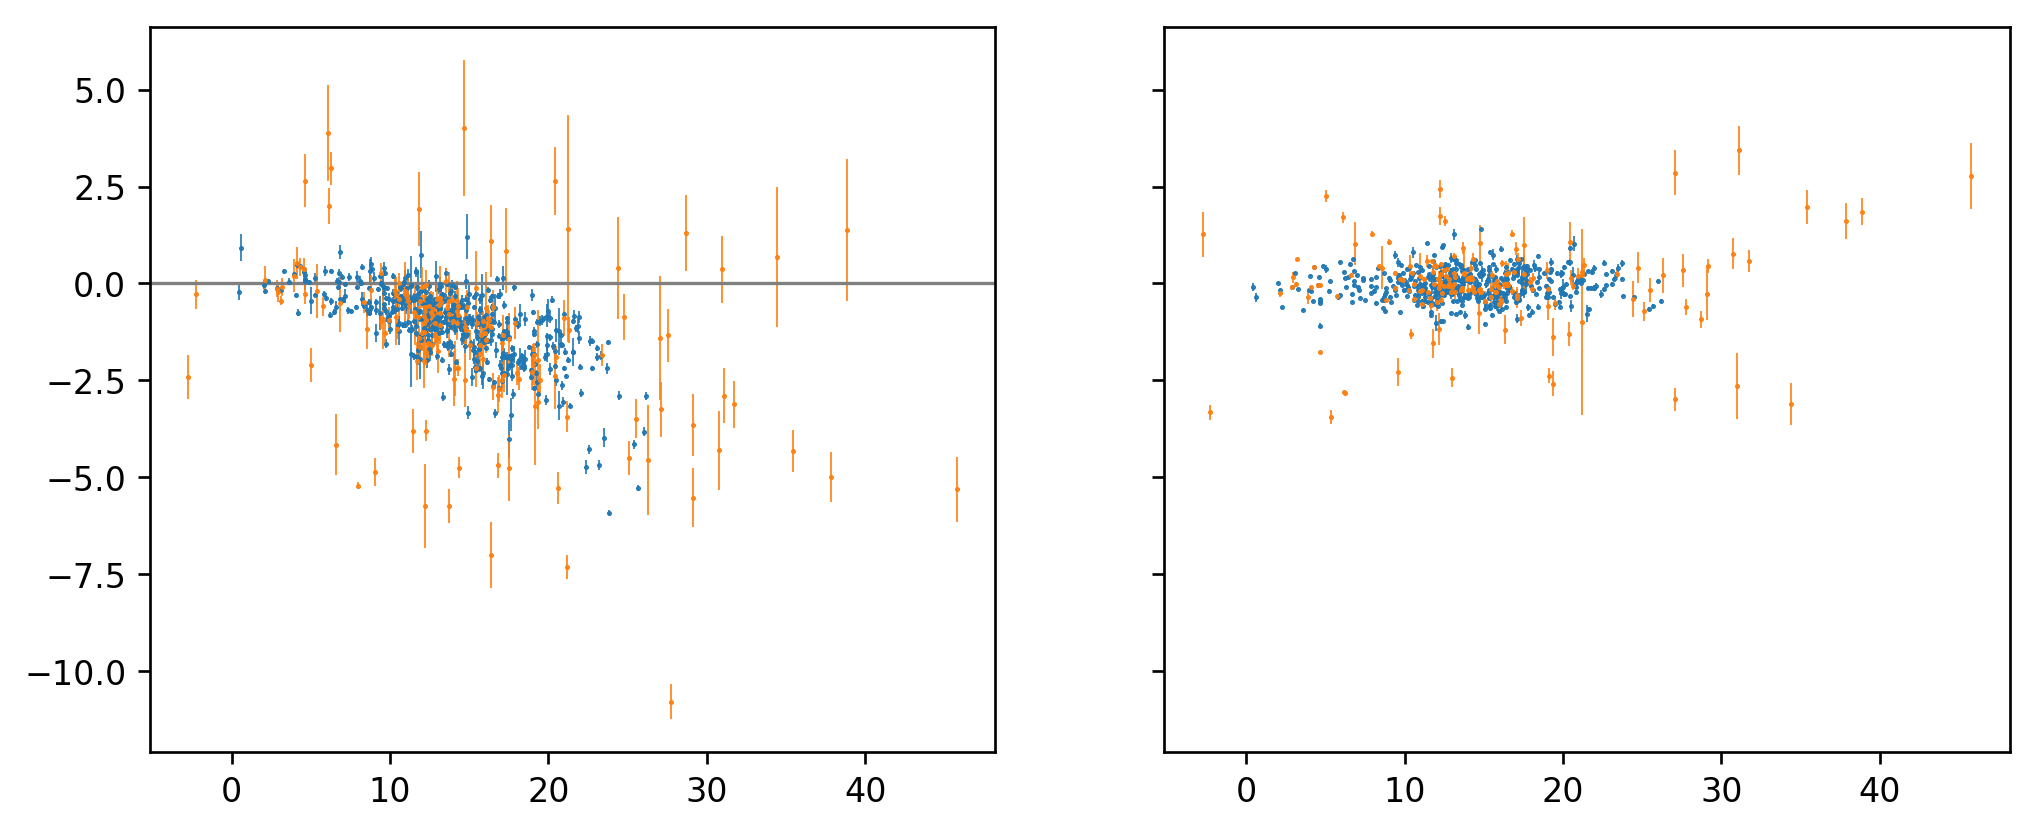

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2_coords.cartesian.z.value,
    hy_dr2.dpmra/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[0].errorbar(
    hy_tgas_coords.cartesian.z.value,
    hy_tgas.dpmra/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

ax[1].errorbar(
    hy_dr2_coords.cartesian.z.value,
    hy_dr2.dpmdec/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas_coords.cartesian.z.value,
    hy_tgas.dpmdec/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);


# for cax in ax: cax.axhline(0, c='k', lw=.5)
# for cax in ax: cax.axvline(0, c='k', lw=.5)
# ax[1].scatter(mockhy_members.spherical.lat.deg, mockhy_members_dpmra/hy_dr2.parallax*4.74, s=1)
# ax[0].set_ylim(-25,15)

# plt.xlim(-3,35);

ax[0].axhline(0, lw=1, c='gray');

In [35]:
clcenter = [17.2, 41.6, 13.6]*u.pc

hy_dr2_coords = kinesis.make_icrs(hy_dr2)
hy_tgas_coords = kinesis.make_icrs(hy_tgas, include_pm_rv=False)

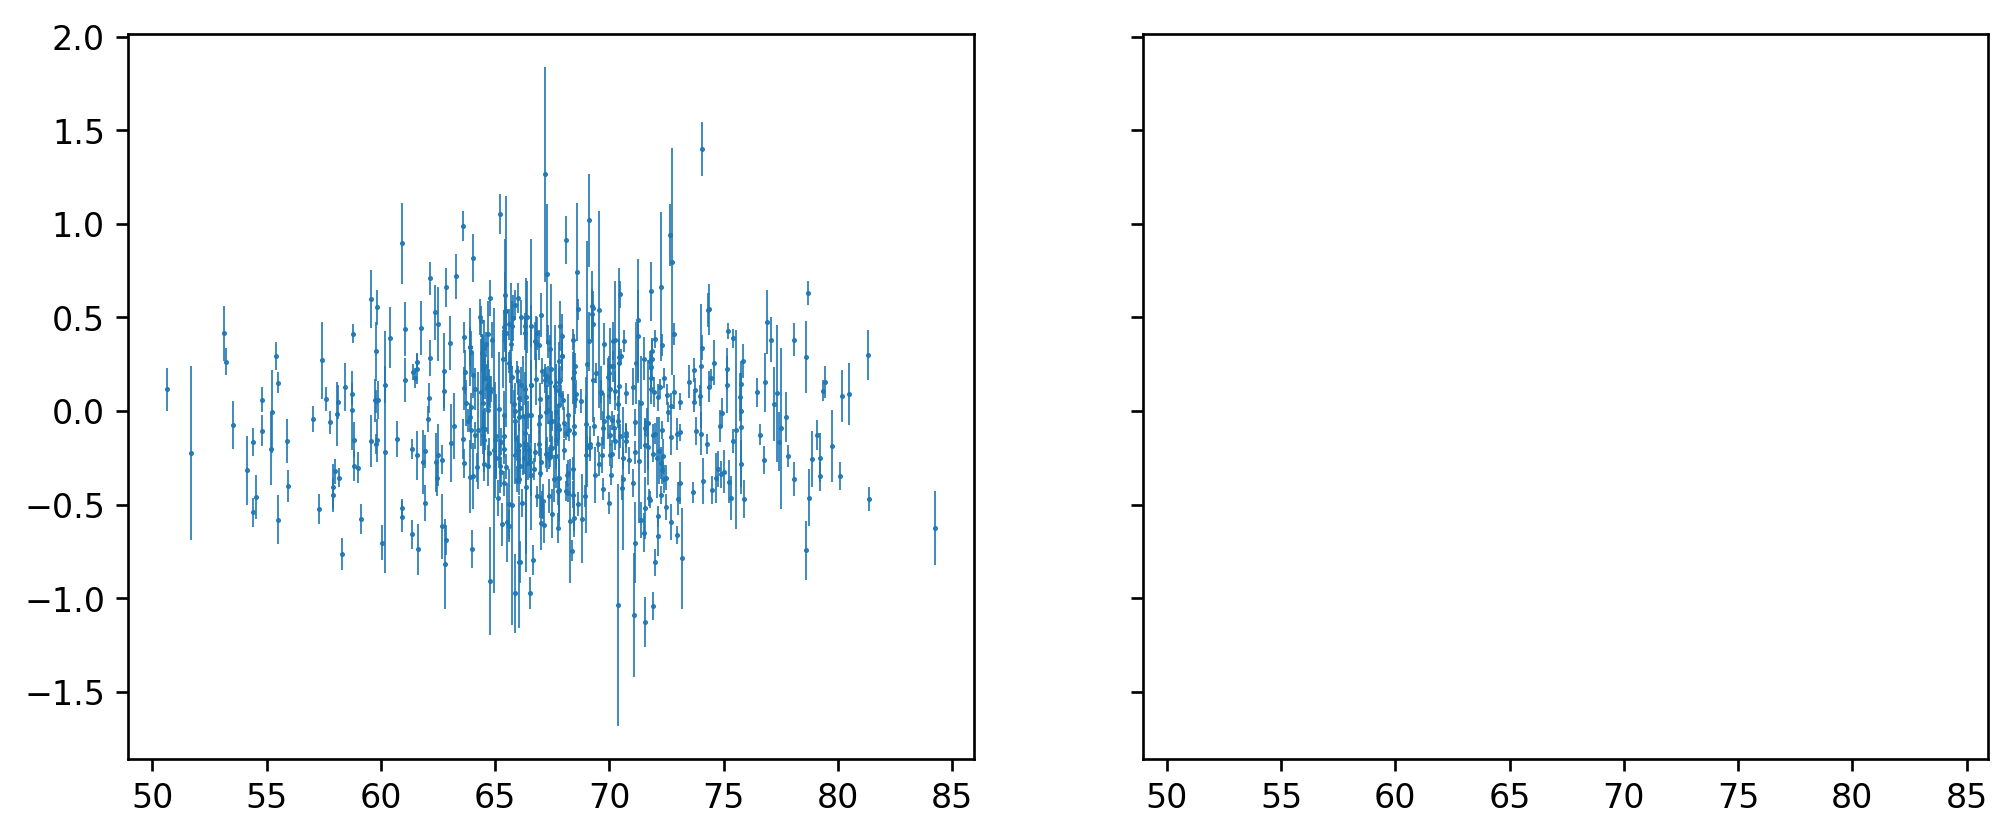

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2.ra,
    hy_dr2.dpmdec/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.pmdec_error, marker='.', ms=1, elinewidth=.5);
# ax[0].errorbar(
#     hy_tgas.ra,
#     hy_tgas.pmdec-pmdec0_tgas,
#     ls='None',
#     yerr=hy_tgas.pmdec_error, marker='.', ms=1, elinewidth=.5);


# for cax in ax: cax.axhline(0, c='k', lw=.5)
# for cax in ax: cax.axvline(0, c='k', lw=.5)
# ax[1].scatter(mockhy_members.spherical.lon.deg, mockhy_members_dpmdec, s=1)
# ax[0].set_ylim(-25,15)

In [34]:
hy_dr2_coords = coord.ICRS(
    hy_dr2.ra.values*u.deg, hy_dr2.dec.values*u.deg, 1e3*u.pc/hy_dr2.parallax.values,
    pm_ra_cosdec=hy_dr2.pmra.values*u.mas/u.yr, pm_dec = hy_dr2.pmdec.values*u.mas/u.yr)
hy_tgas_coords = coord.ICRS(
    hy_tgas.ra.values*u.deg, hy_tgas.dec.values*u.deg, 1e3*u.pc/hy_tgas.parallax.values,
    pm_ra_cosdec=hy_tgas.pmra.values*u.mas/u.yr, pm_dec = hy_tgas.pmdec.values*u.mas/u.yr)

hy_dr2_coords_mean = coord.ICRS(
    hy_dr2_coords.cartesian.xyz,
    v_x=[vmean[0]]*len(hy_dr2_coords),
    v_y=[vmean[1]]*len(hy_dr2_coords),
    v_z=[vmean[2]]*len(hy_dr2_coords),
    representation_type='cartesian',
    differential_type='cartesian').spherical

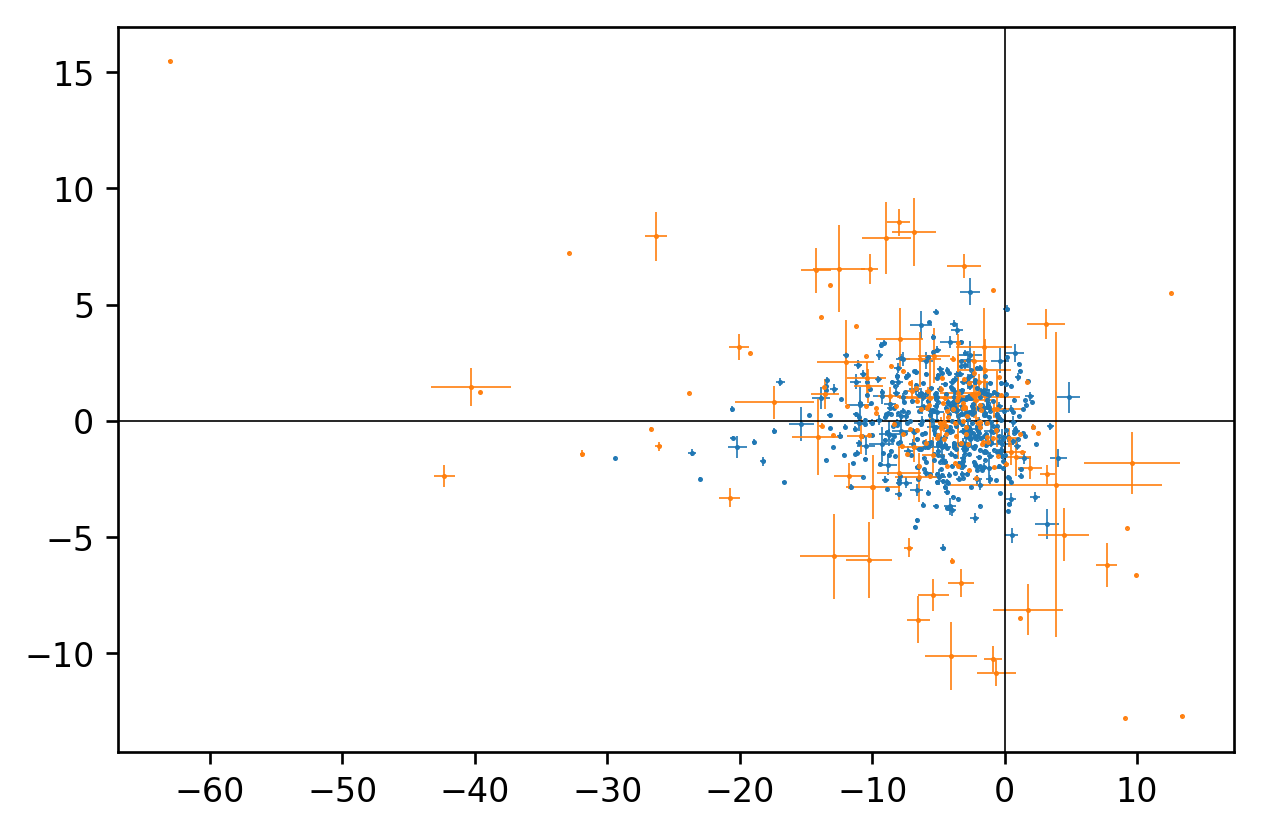

In [35]:
# fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
fig, ax = plt.subplots(1, 1,)
plt.errorbar(
    hy_dr2.pmra-pmra0_dr2,
    hy_dr2.pmdec-pmdec0_dr2,
    ls='None',
    xerr=hy_dr2.pmra_error, yerr=hy_dr2.pmdec_error, marker='.', ms=1, elinewidth=.5);
plt.errorbar(
    hy_tgas.pmra-pmra0_tgas,
    hy_tgas.pmdec-pmdec0_tgas,
    ls='None',
    xerr=hy_tgas.pmra_error, yerr=hy_tgas.pmdec_error, marker='.', ms=1, elinewidth=.5);
plt.axhline(0, c='k', lw=.5)
plt.axvline(0, c='k', lw=.5);

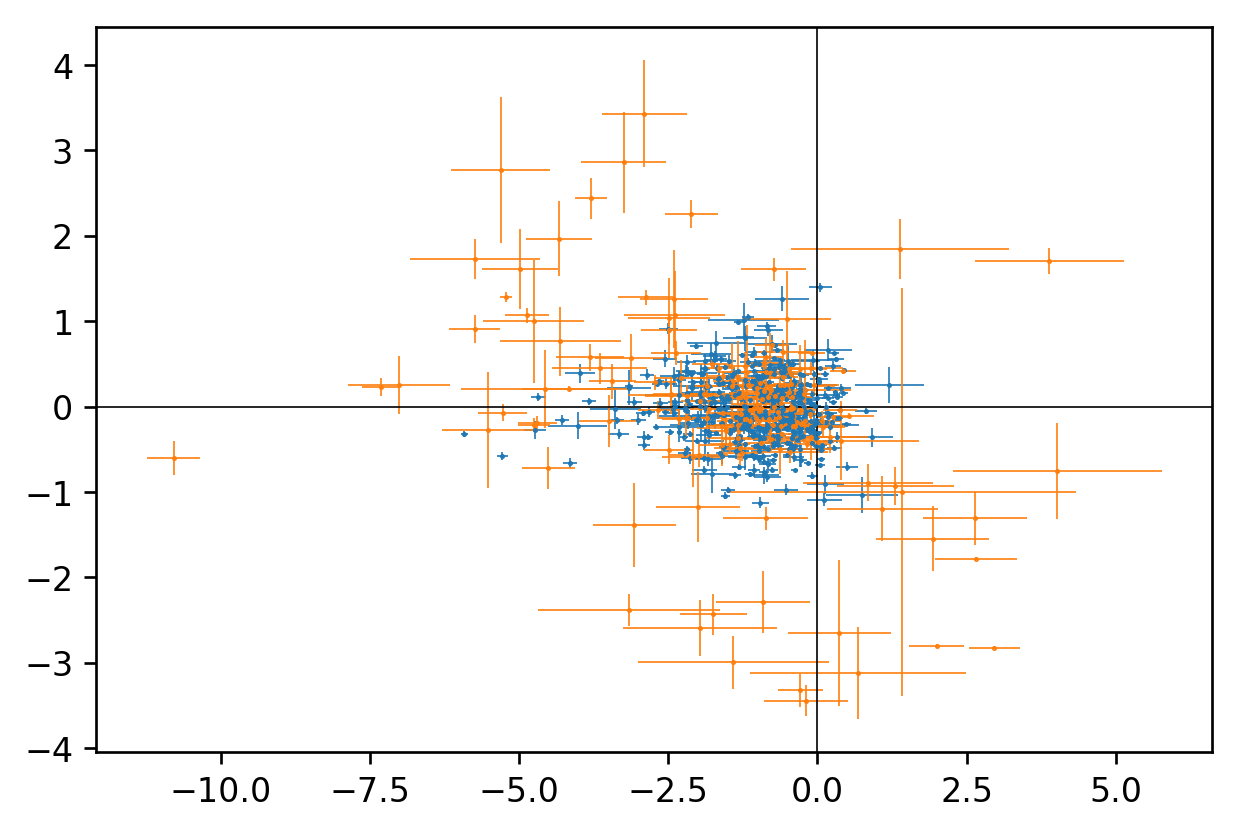

In [284]:
# fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
fig, ax = plt.subplots(1, 1,)
plt.errorbar(
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    xerr=hy_dr2.vra_error, yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);

plt.errorbar(
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

plt.axhline(0, c='k', lw=.5)
plt.axvline(0, c='k', lw=.5);

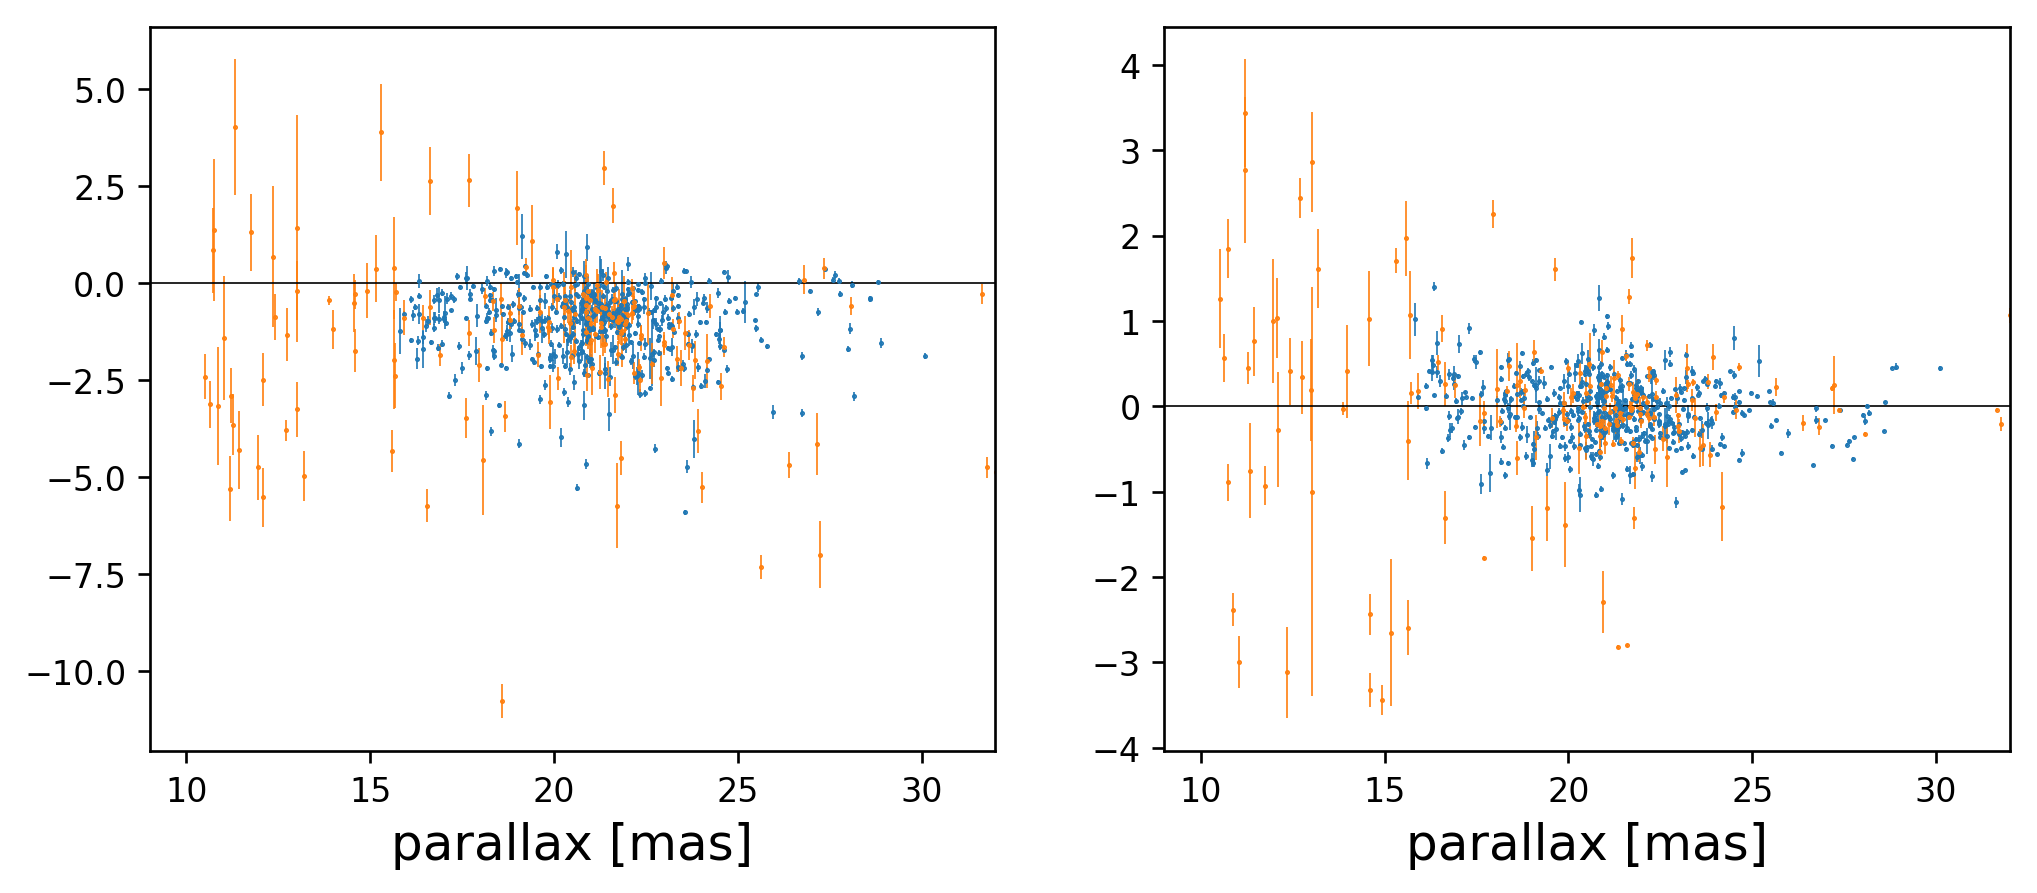

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    hy_dr2.parallax,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_dr2.parallax,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);


ax[0].errorbar(
    hy_tgas.parallax,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.parallax,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

ax[0].set_xlim(9,32)
ax[1].set_xlim(9,32);
ax[0].axhline(0, c='k', lw=.5)
ax[1].axhline(0, c='k', lw=.5)

ax[0].set_xlabel('parallax [mas]')
ax[1].set_xlabel('parallax [mas]');

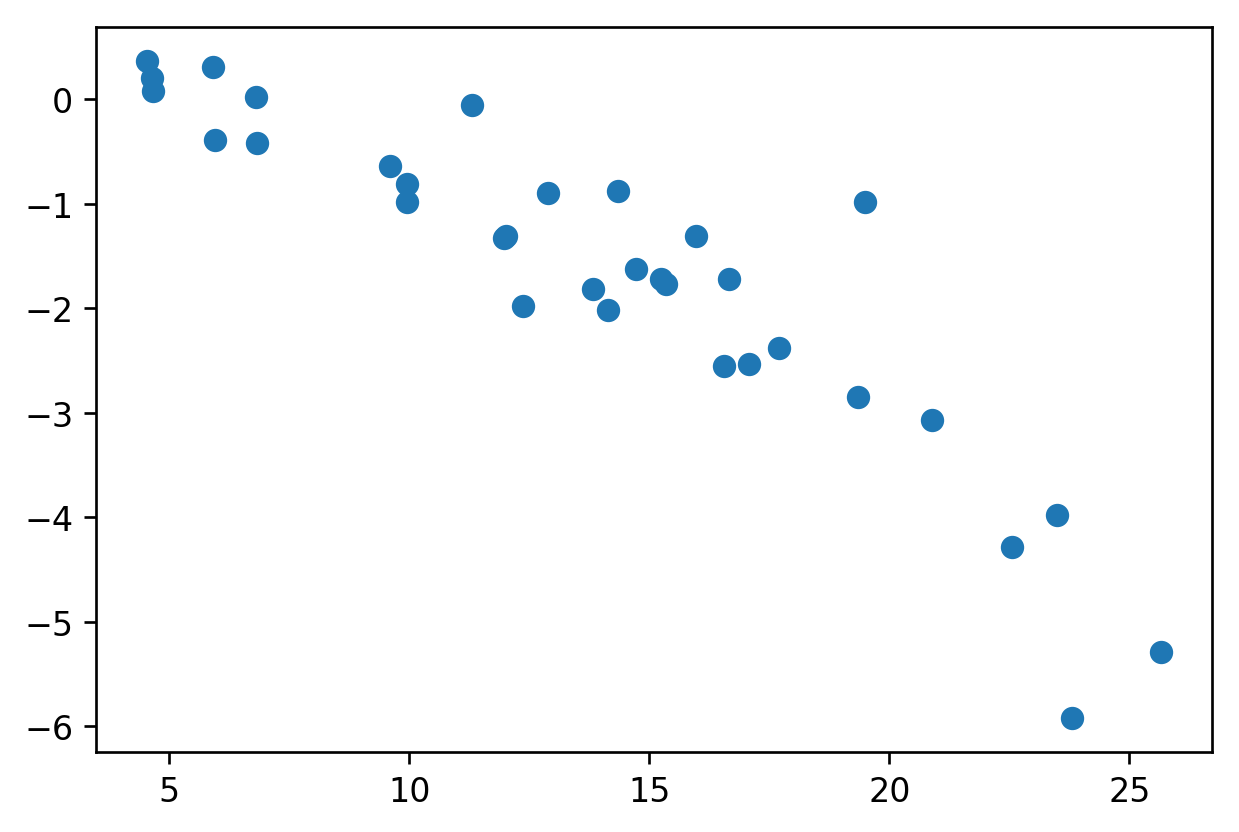

In [155]:
slc = np.fabs(   np.sin(np.deg2rad(hy_dr2.ra))-0.85)<0.02
plt.scatter(
    hy_dr2_coords.cartesian.z.value[slc],
    ((hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74)[slc], );

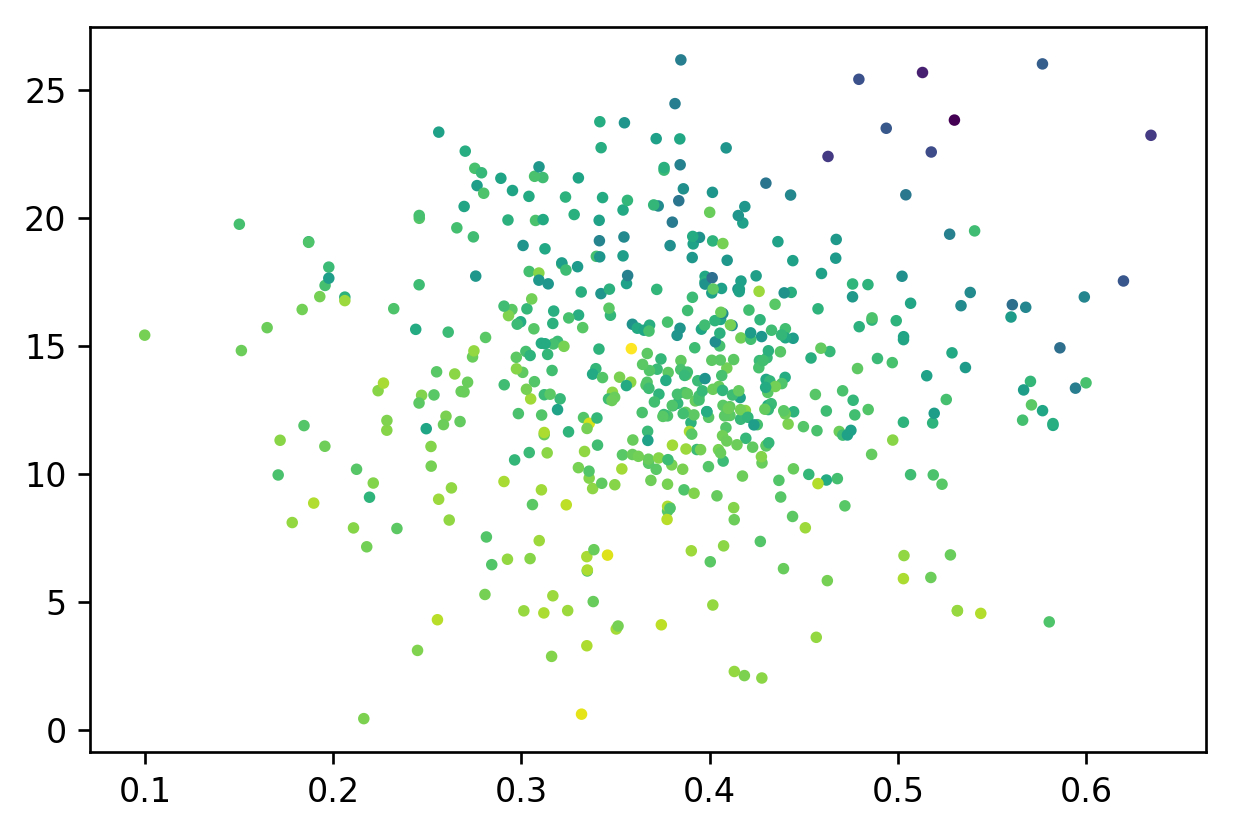

In [307]:
plt.scatter(
    np.cos(np.deg2rad(hy_dr2.ra)),
    hy_dr2_coords.cartesian.z.value,
    c=(hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74, s=6);

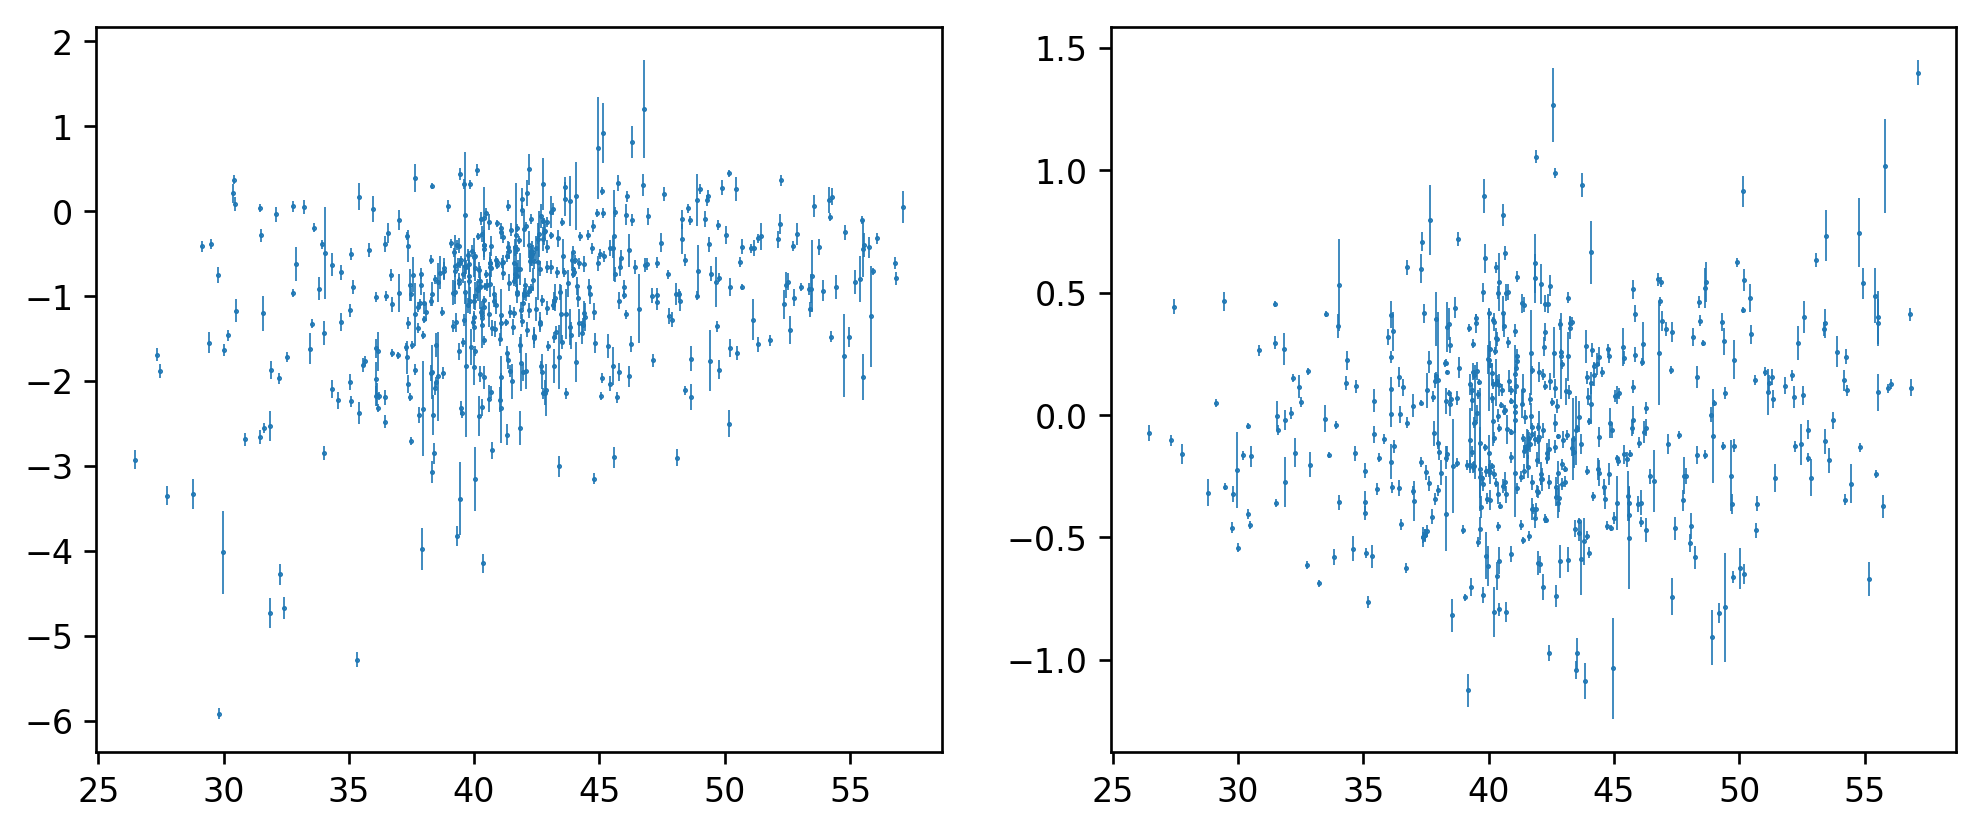

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    hy_dr2_coords.cartesian.y.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_dr2_coords.cartesian.y.value,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

In [298]:
np.corrcoef(hy_dr2_coords.cartesian.x.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,)

array([[ 1.        , -0.23902276],
       [-0.23902276,  1.        ]])

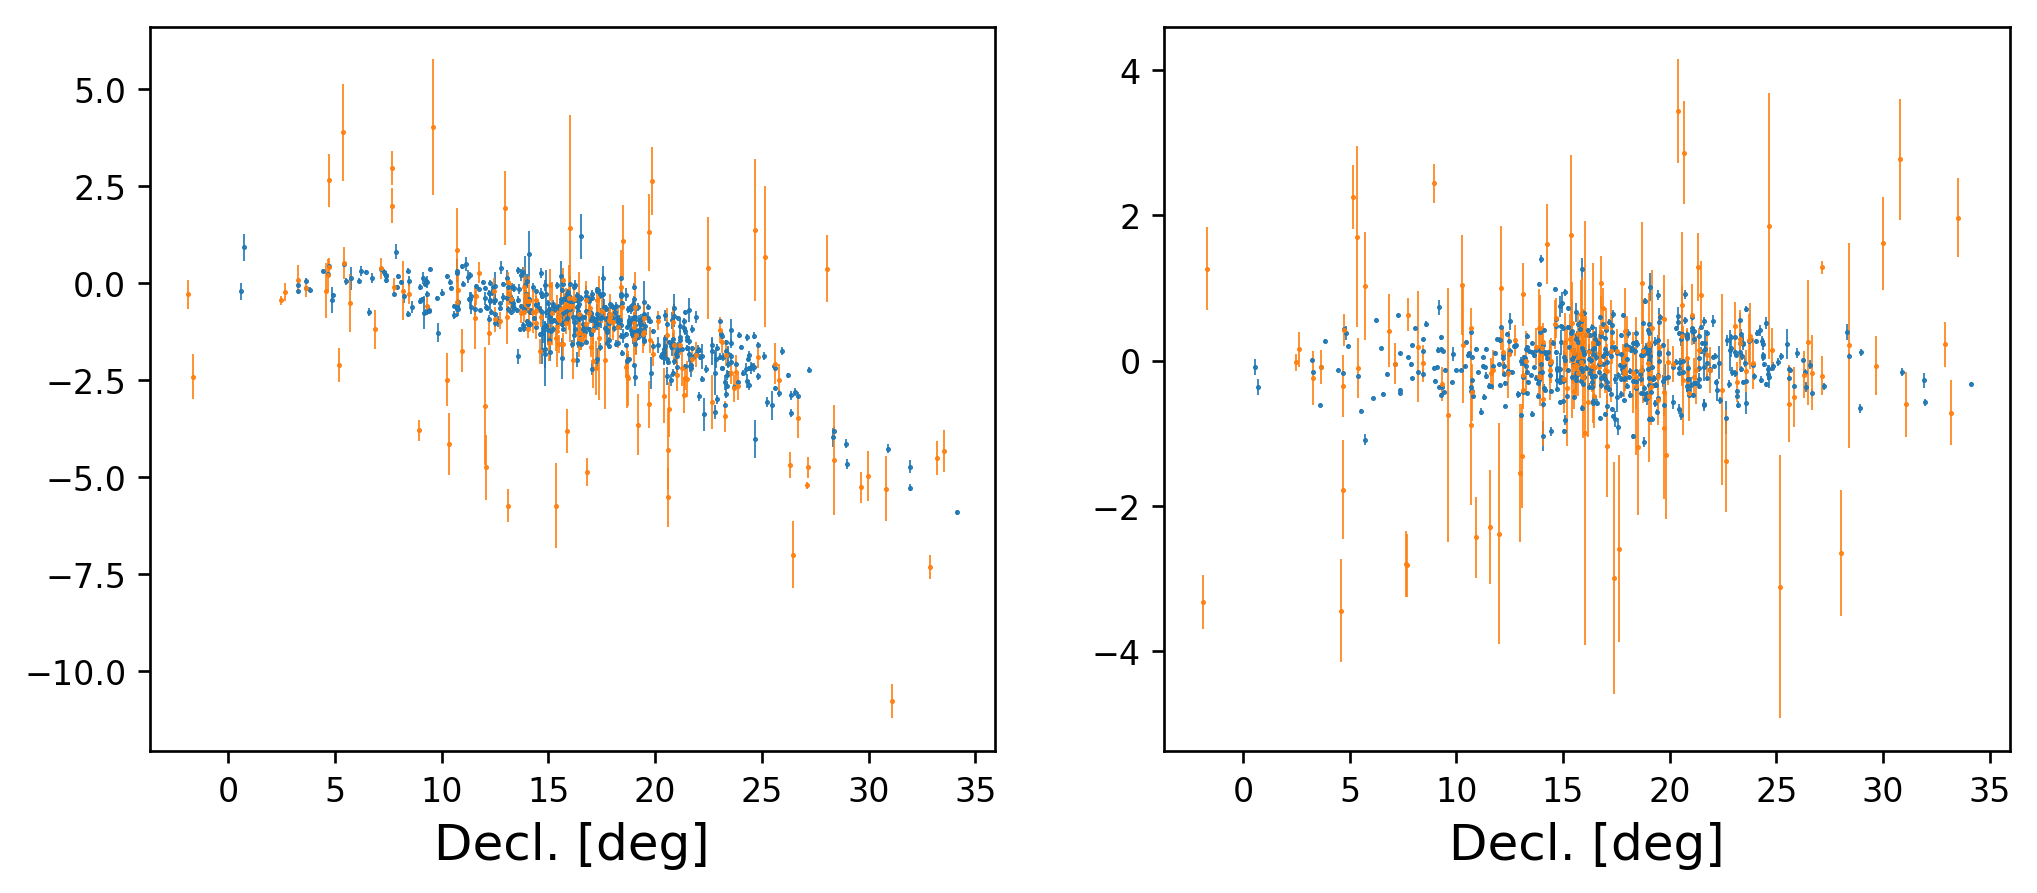

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);



ax[0].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

ax[0].set_xlabel('Decl. [deg]')
ax[1].set_xlabel('Decl. [deg]');

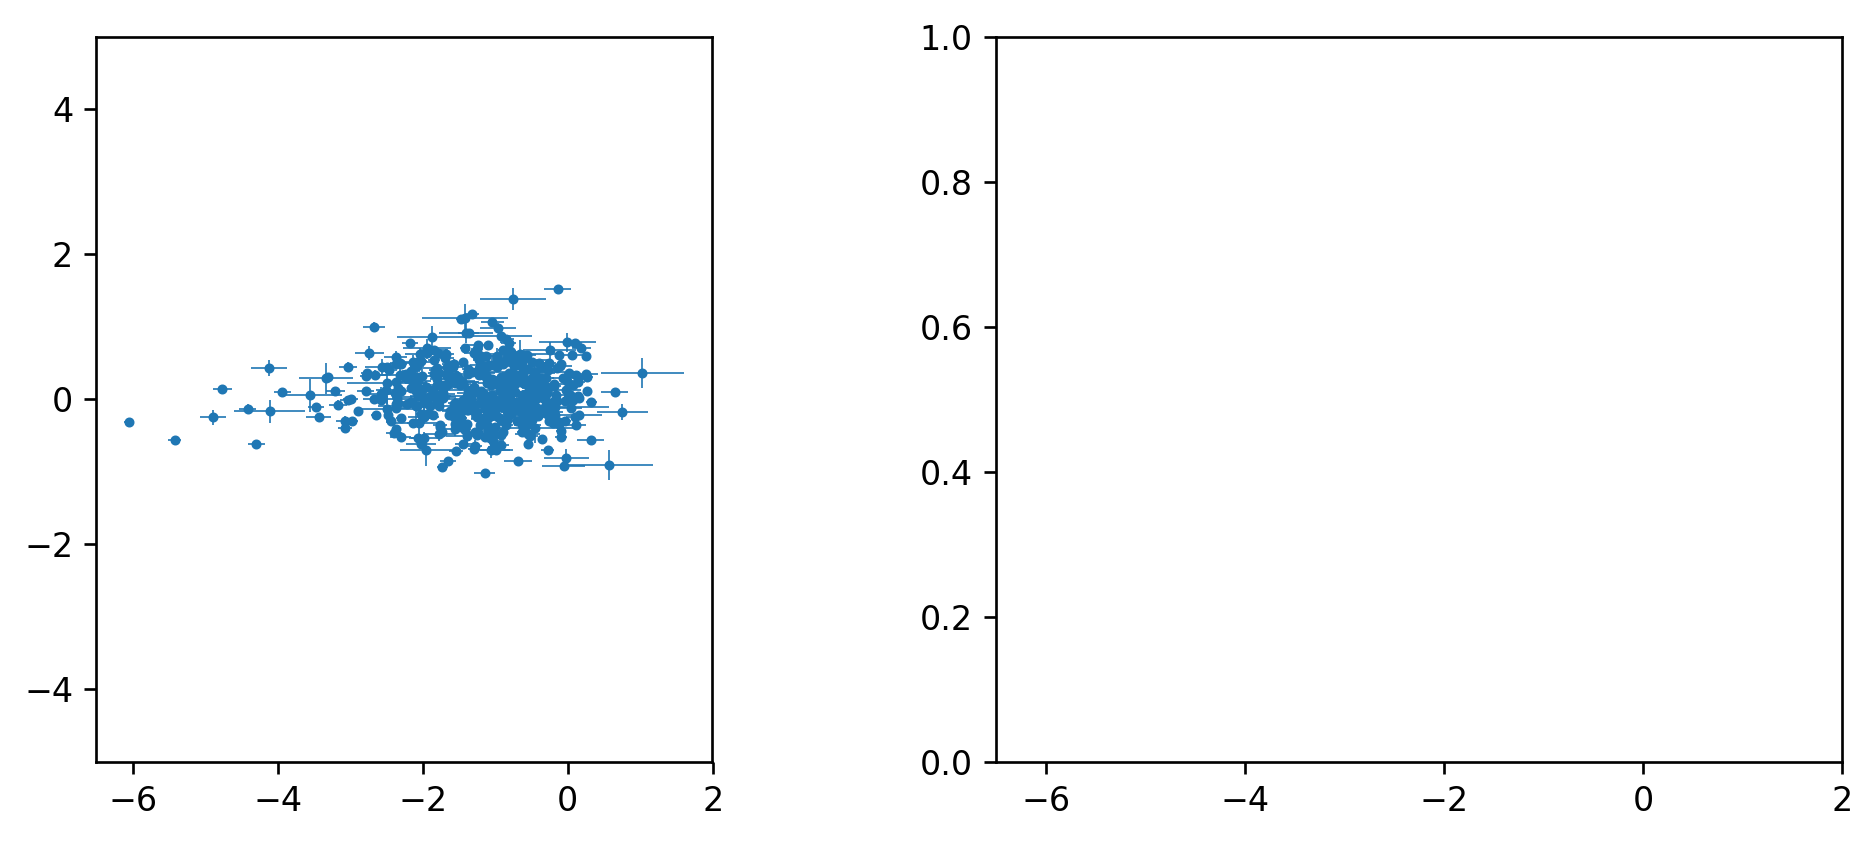

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].errorbar(
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     (hy_dr2.radial_velocity-rv0_dr2),
    ls='None', xerr=hy_dr2.vra_error,
    yerr=hy_dr2.vdec_error, marker='.', ms=4, elinewidth=.5);
# ax[1].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
ax[0].set_ylim(-5,5)
ax[0].set_aspect('equal')

# ax[0].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

In [215]:
def add_xv(df, frame, unit=u.pc):
    """
    Add cartesian coordinates x, y, z, vx, vy, vz for a given `frame`
    
    df : pd.DataFrame
        Gaia DR2 data
    frame : astropy coordinate frame
        Frame to calculate coordinates in
    
    Returns df with x, y, z, vx, vy, vz columns added.
    """
    df = df.copy()
    c = make_icrs(df).transform_to(frame)
    df['x'], df['y'], df['z'] = c.cartesian.xyz.to(u.pc).value
    df['vx'], df['vy'], df['vz'] = c.velocity.d_xyz.value
    return df
hy_dr2 = hy_dr2.pipe(add_xv, coord.Galactic)

In [216]:
aa = hy_dr2.dropna(subset=['radial_velocity'])[['x','y','z', 'vx','vy','vz']]

In [222]:
aa_res = aa[['vx','vy','vz']] - aa[['vx','vy','vz']].mean()

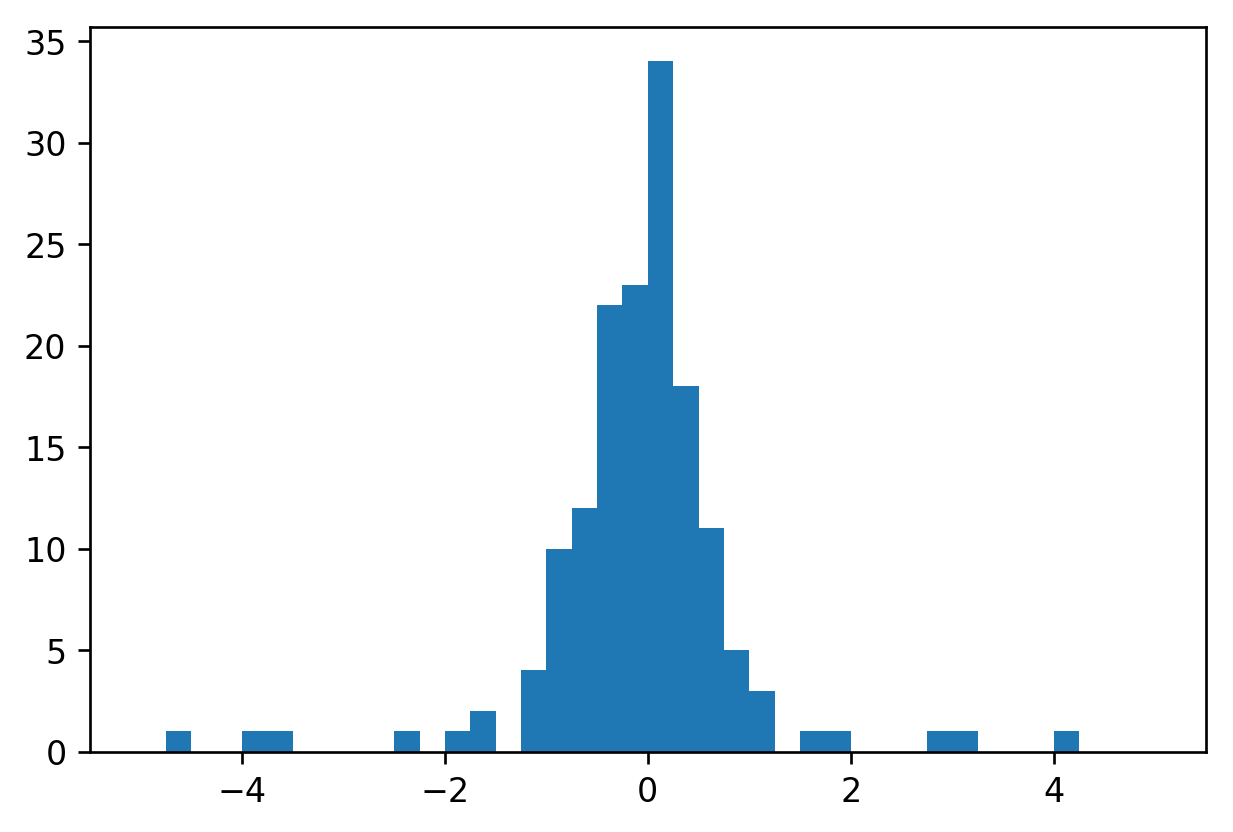

In [241]:
plt.hist(aa_res.vx-aa_res.vx.median(), bins=np.linspace(-5,5,41));

(-10, 10)

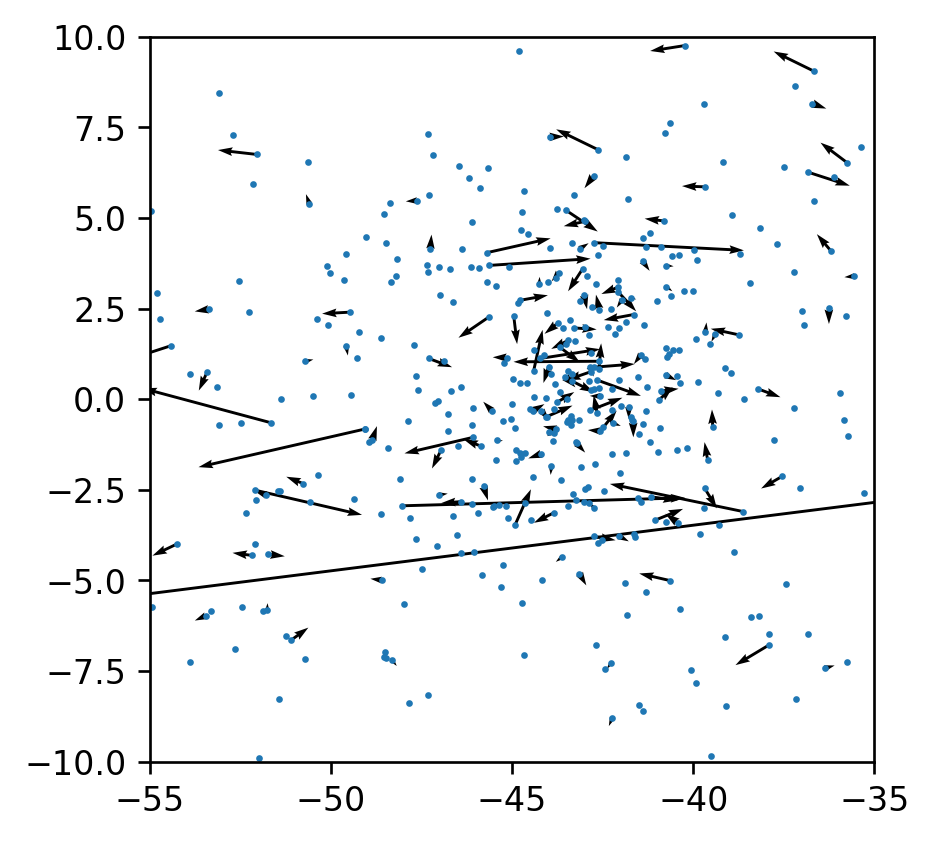

In [235]:
plt.axes(aspect='equal')
plt.quiver(aa.x, aa.y, aa_res.vx-aa_res.vx.median(), aa_res.vy, width=0.004);
plt.scatter(hy_dr2.x, hy_dr2.y, s=1);
plt.xlim(-55,-35)
plt.ylim(-10, 10)

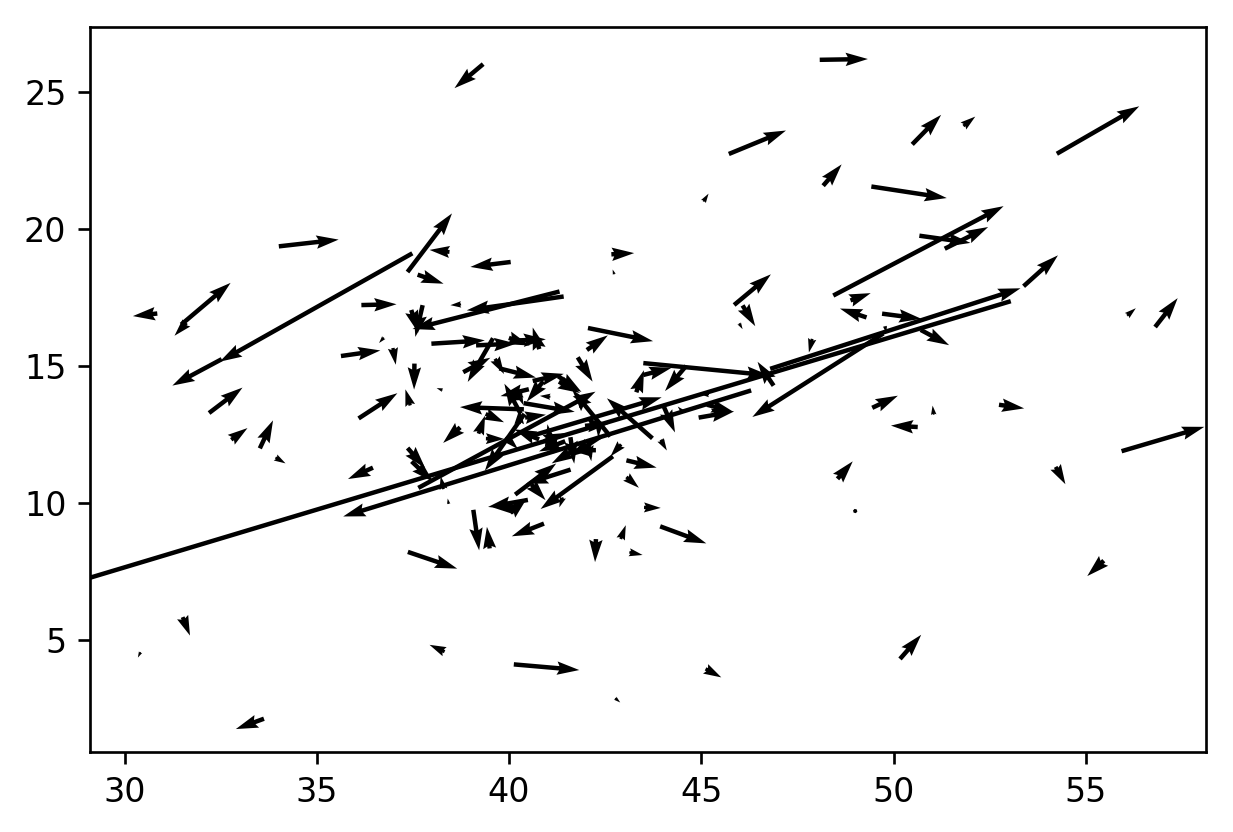

In [212]:
plt.quiver(aa.y, aa.z, aa_res.vy, aa_res.vz, width=0.004);

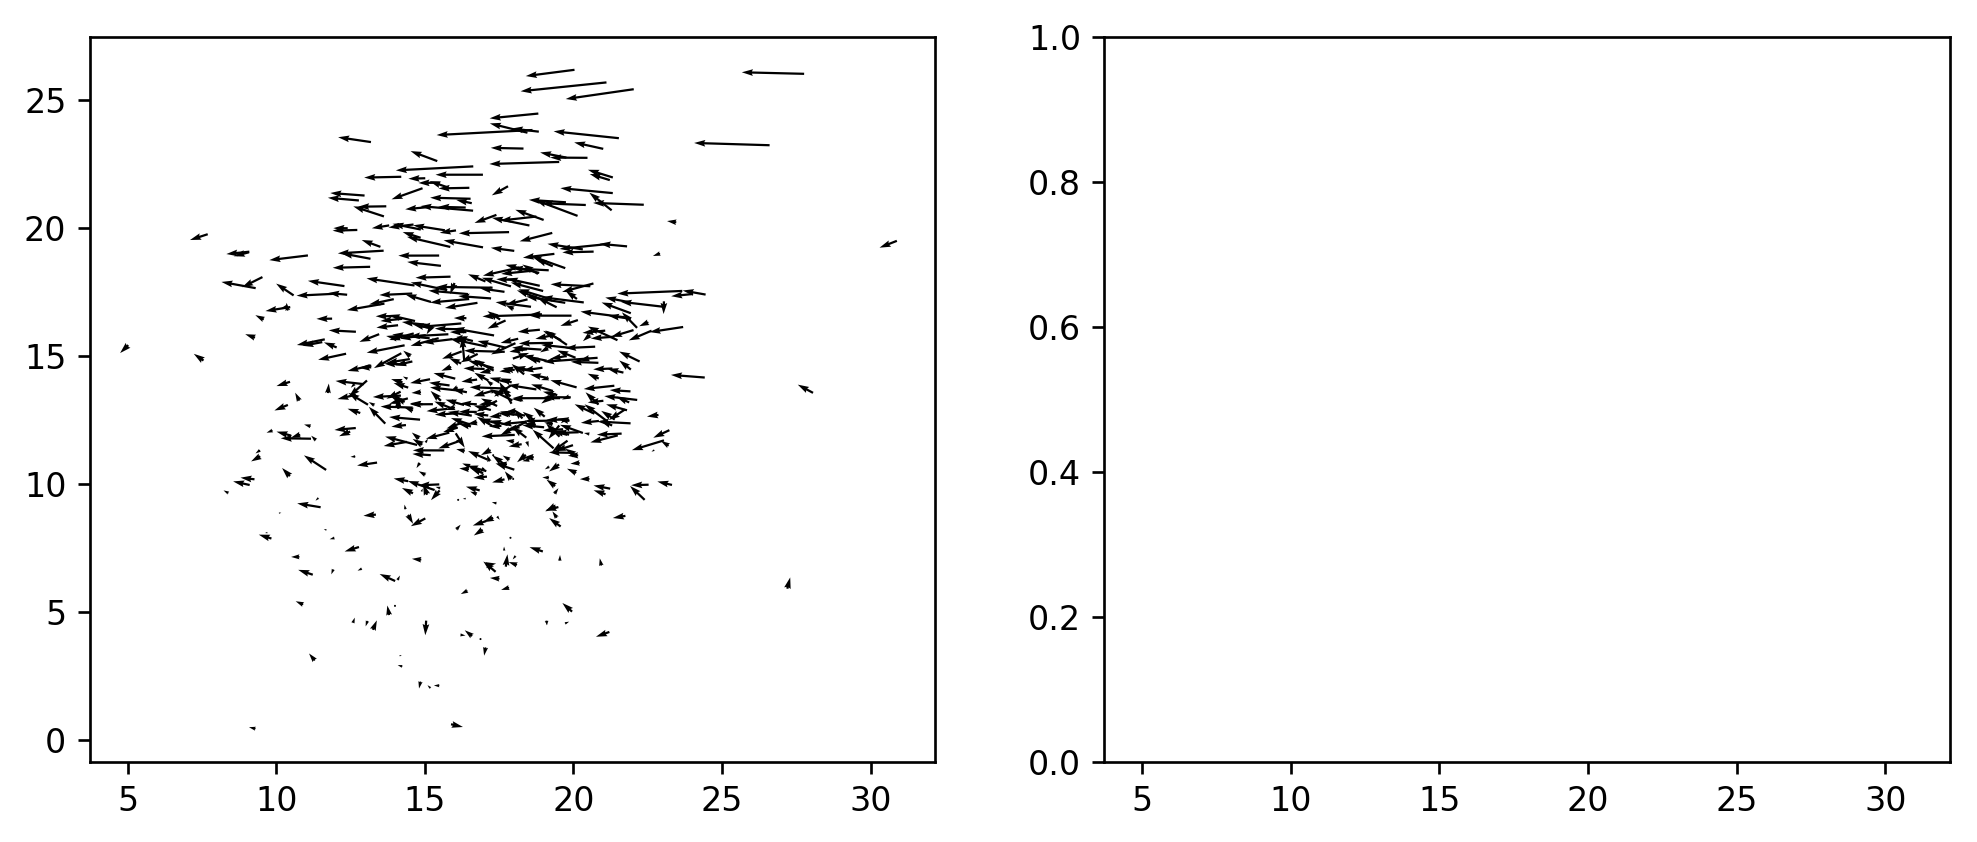

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True)

ax[0].quiver(
    hy_dr2_coords.cartesian.x.value, hy_dr2_coords.cartesian.z.value,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74, (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74
)

# ax[0].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_dr2_coords.cartesian.x.value,
#     (hy_dr2.pmdec-pmdec0_dr2)/hy_dr2.parallax*4.74,
#     ls='None',
#     yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);



# ax[0].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# ax[1].errorbar(
#     hy_tgas_coords.cartesian.x.value,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.errorbar(
#     (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
#     (hy_tgas.pmdec-pmdec0_tgas)/hy_tgas.parallax*4.74,
#     ls='None',
#     xerr=hy_tgas.vra_error, yerr=hy_tgas.vdec_error, marker='.', ms=1, elinewidth=.5);

# plt.axhline(0, c='k', lw=.5)
# plt.axvline(0, c='k', lw=.5);

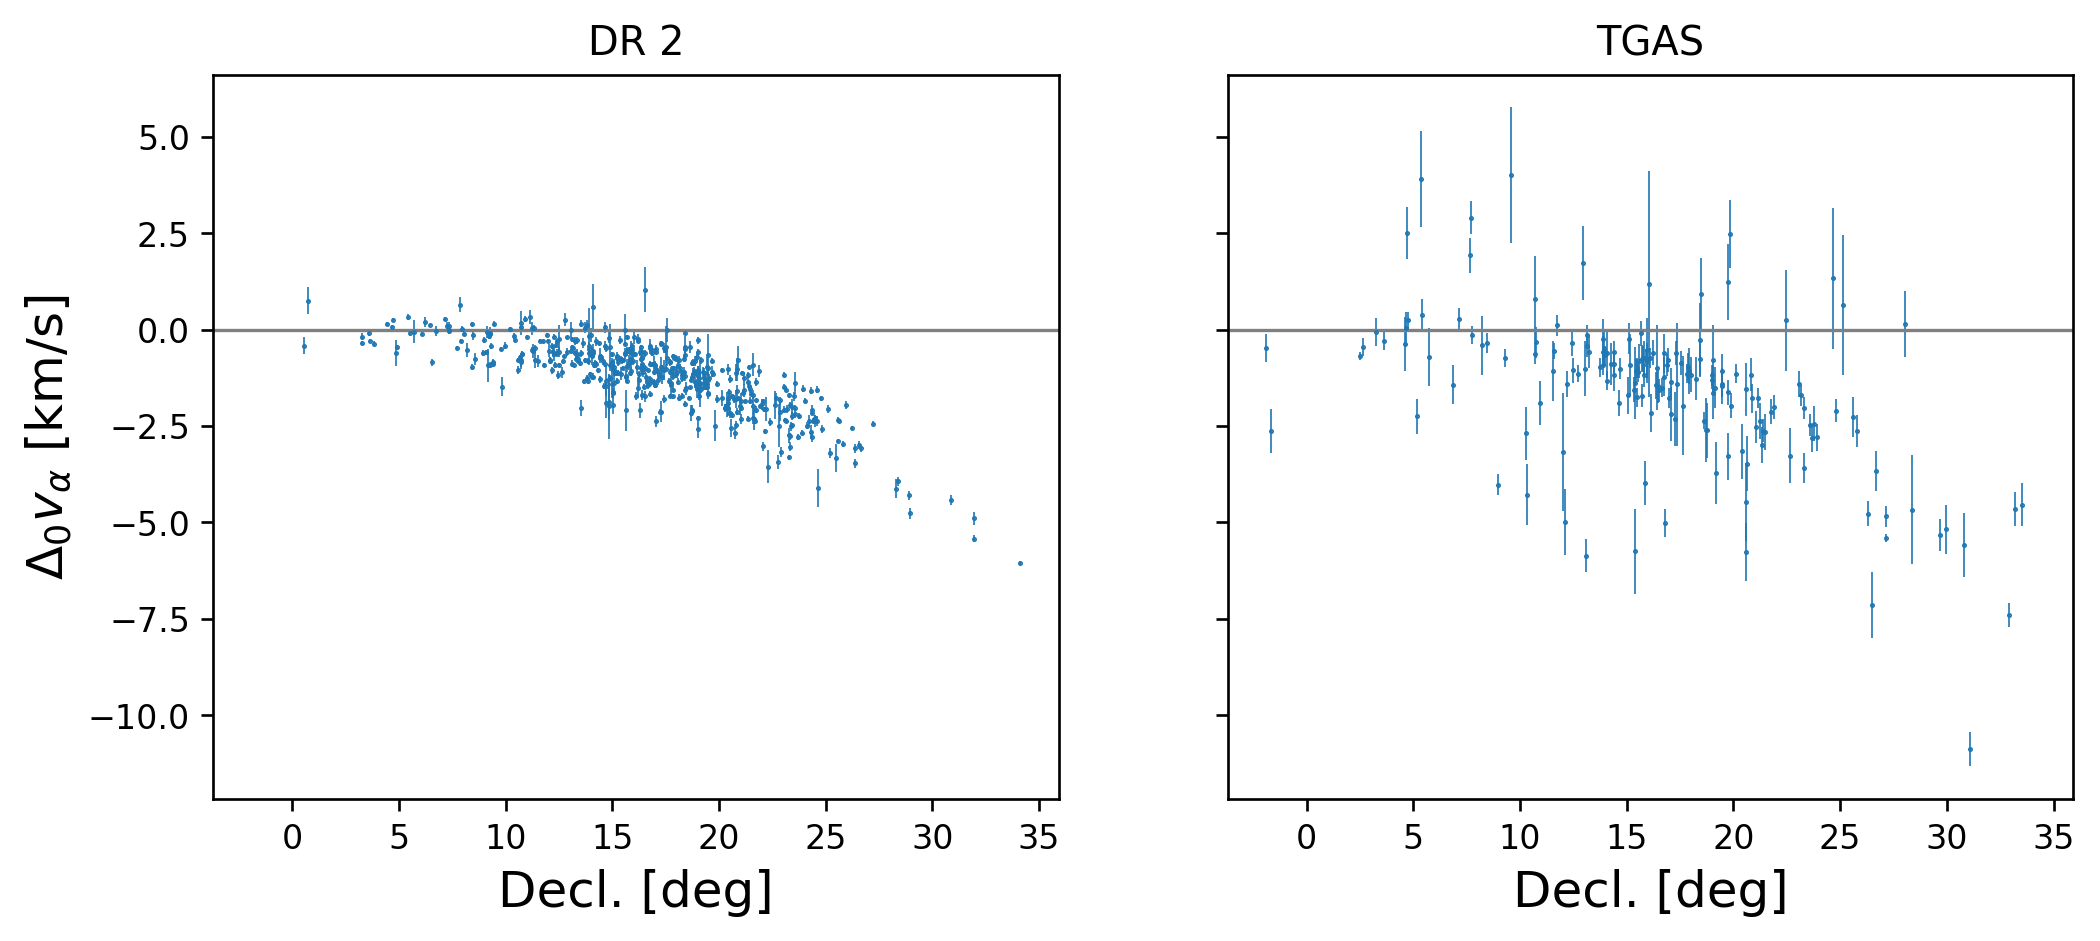

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax[0].errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
ax[1].errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

ax[0].axhline(0, c='gray', lw=1)
ax[1].axhline(0, c='gray', lw=1)
ax[0].set_title('DR 2')
ax[1].set_title('TGAS')

ax[0].set_xlabel('Decl. [deg]')
ax[1].set_xlabel('Decl. [deg]')
ax[0].set_ylabel(r'$\Delta_0 v_\alpha$ [km/s]');

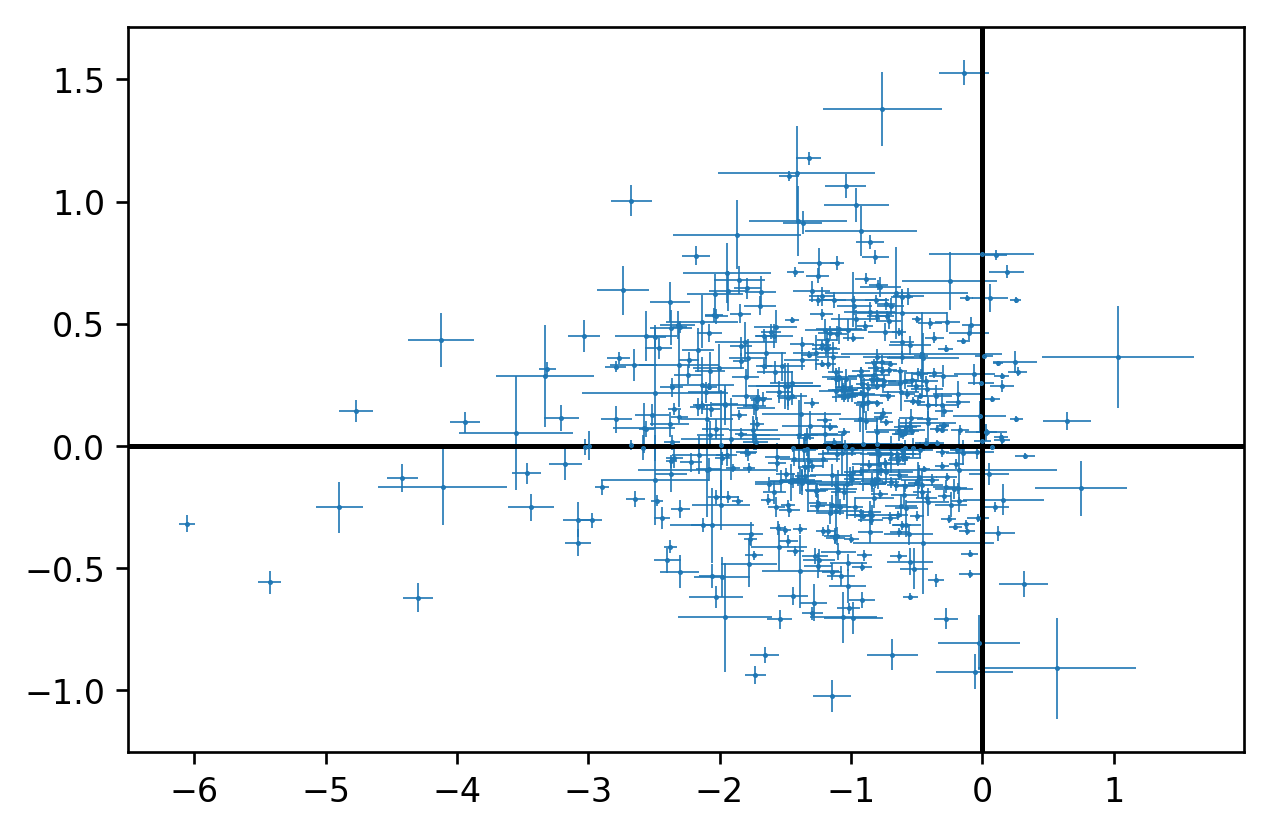

In [43]:
plt.errorbar(
    (hy_dr2.pmra-hy_dr2_coords_mean.differentials['s'].d_lon.value)/hy_dr2.parallax*4.74,
    (hy_dr2.pmdec-hy_dr2_coords_mean.differentials['s'].d_lat.value)/hy_dr2.parallax*4.74,
    ls='None',
    xerr=hy_dr2.vra_error, yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
plt.axhline(0, c='k')
plt.axvline(0, c='k');

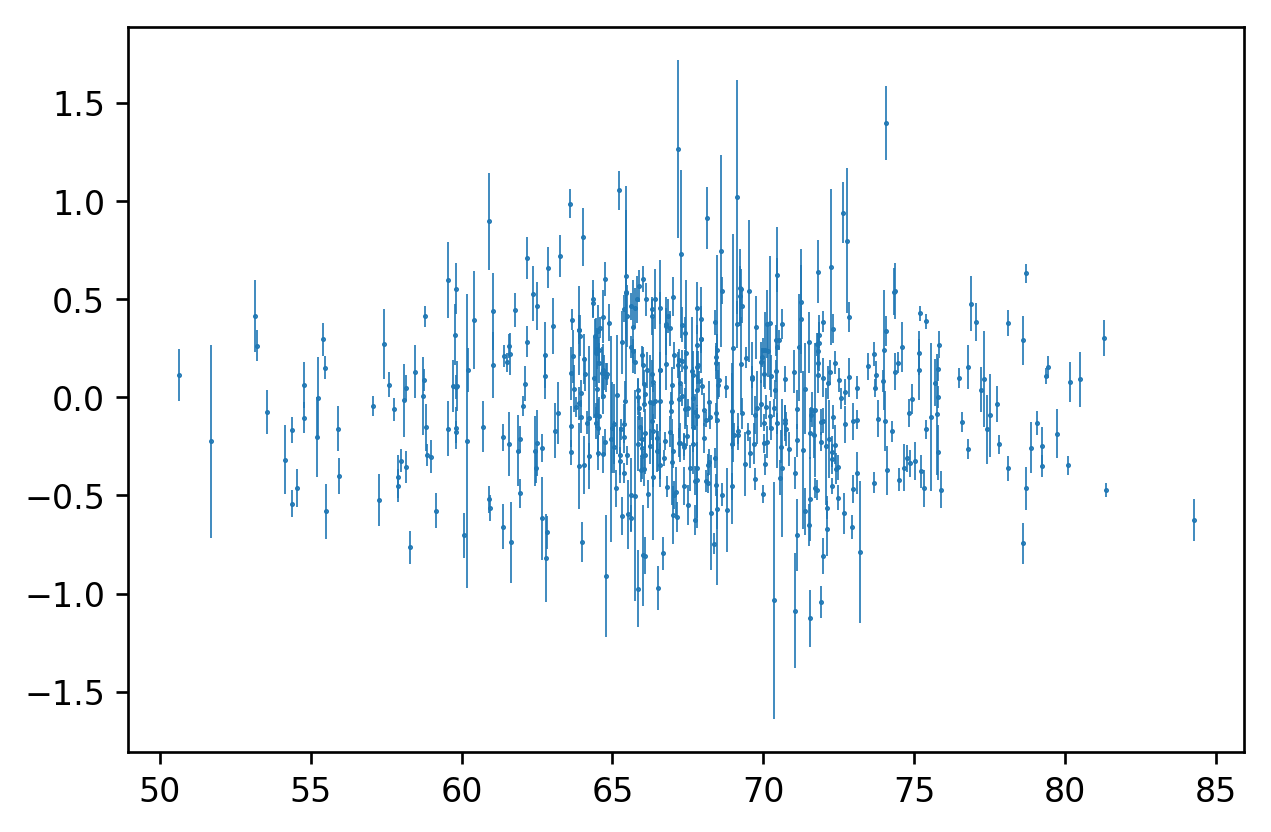

In [43]:
plt.errorbar(
    hy_dr2.ra,
    (hy_dr2.pmdec-hy_dr2_coords_mean.differentials['s'].d_lat.value)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

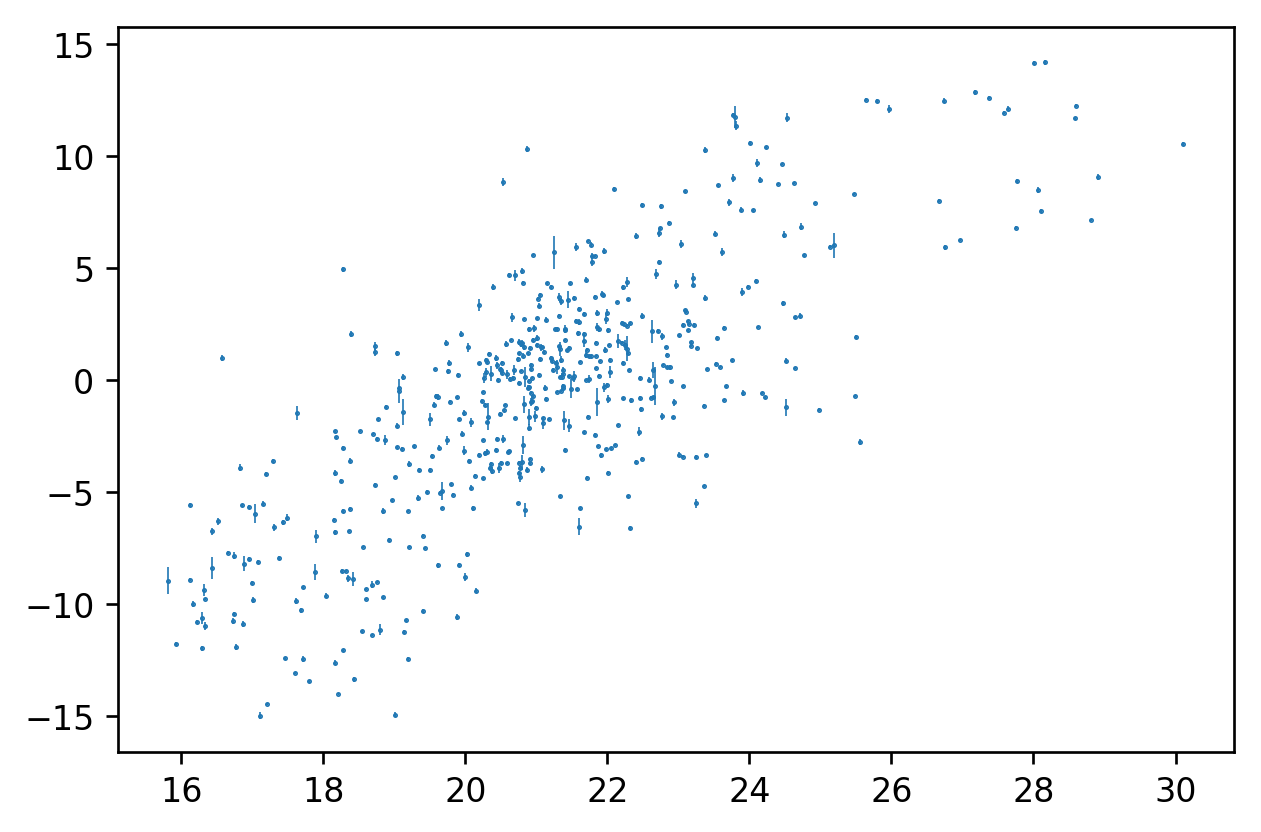

In [49]:
plt.errorbar(
    hy_dr2.parallax,
    (hy_dr2.pmra-hy_dr2.pmra.mean())/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

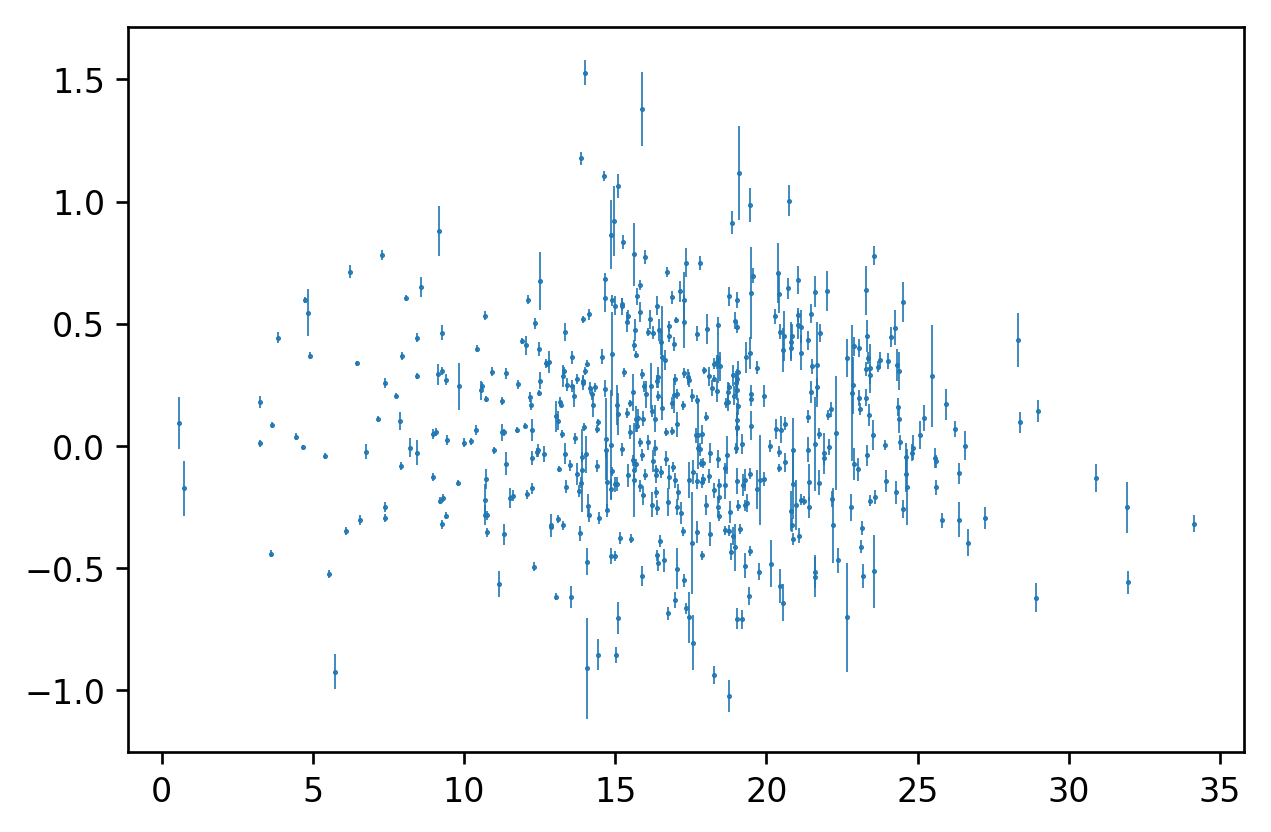

In [46]:
plt.errorbar(
    hy_dr2.dec,
    (hy_dr2.pmdec-hy_dr2_coords_mean.differentials['s'].d_lat.value)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vdec_error, marker='.', ms=1, elinewidth=.5);
# plt.axhline(0, c='k')
# plt.axvline(0, c='k');

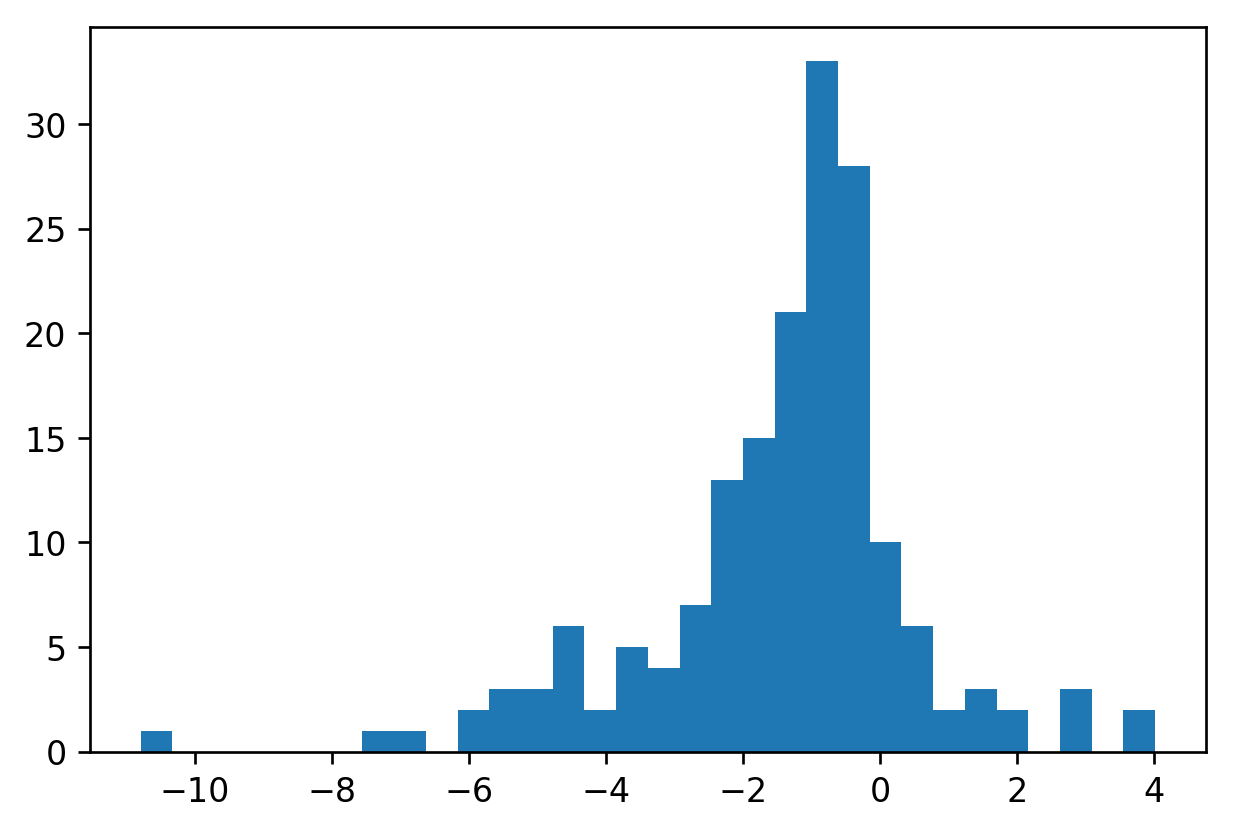

In [149]:
plt.hist((hy_dr2.pmra-hy_dr2_coords_mean.differentials['s'].d_lon.value)/hy_dr2.parallax*4.74, 32);

In [67]:
hy_dr2[['pmra','pmdec']].describe()

pmra       pmdec
count  515.000000  515.000000
mean   102.742181  -27.098107
std     24.912271   15.682757
min     42.851297  -77.695168
25%     86.651104  -37.888986
50%    103.018496  -27.228486
75%    114.312377  -18.314095
max    187.065993   24.721862

In [125]:
# vmean = [-5.96, 45.60, 5.57] * u.km/u.s   # cartesian equatorial
N = 200
vi = np.random.normal(0, 0.3, size=(N, 3))

cartesian_coords = coord.ICRS(
    hy_dr2_coords.cartesian.xyz,
    v_x=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    v_y=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    v_z=np.random.normal(0, 0.3, size=len(hy_dr2_coords))*u.km/u.s,
    representation_type='cartesian',
    differential_type='cartesian')
pmra = cartesian_coords.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
pmdec = cartesian_coords.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value

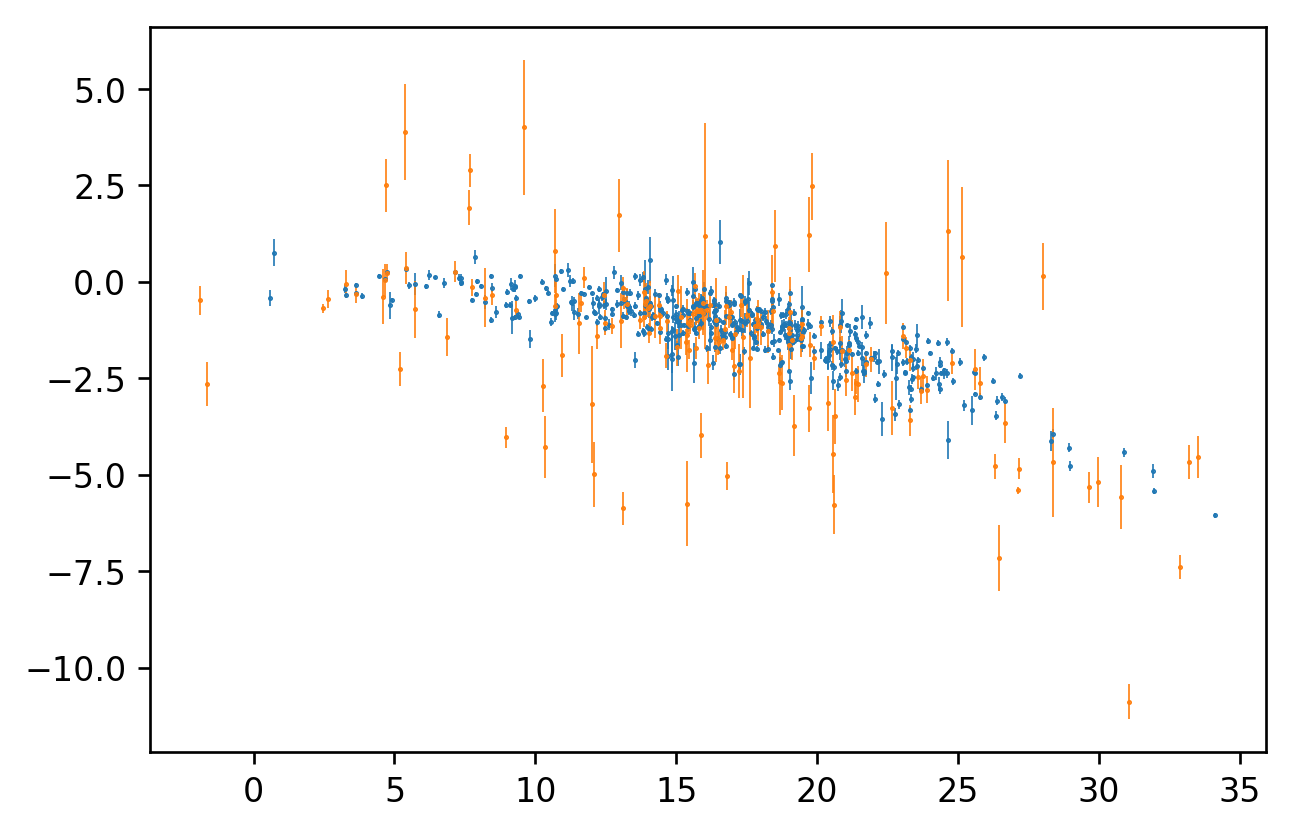

In [269]:

# plt.scatter(cartesian_coords.spherical.lat, pmra, s=1, c='k')

plt.errorbar(
    hy_dr2.dec,
    (hy_dr2.pmra-pmra0_dr2)/hy_dr2.parallax*4.74,
    ls='None',
    yerr=hy_dr2.vra_error, marker='.', ms=1, elinewidth=.5);
plt.errorbar(
    hy_tgas.dec,
    (hy_tgas.pmra-pmra0_tgas)/hy_tgas.parallax*4.74,
    ls='None',
    yerr=hy_tgas.vra_error, marker='.', ms=1, elinewidth=.5);

In [268]:
np.cos(np.deg2rad(hy_dr2.ra)).describe(), np.sin(np.deg2rad(hy_dr2.ra)).describe()

(count    515.000000
 mean       0.377893
 std        0.088009
 min        0.099914
 25%        0.318133
 50%        0.383532
 75%        0.428004
 max        0.634289
 Name: ra, dtype: float64, count    515.000000
 mean       0.920910
 std        0.037344
 min        0.773096
 25%        0.903777
 50%        0.923527
 75%        0.948046
 max        0.994996
 Name: ra, dtype: float64)

In [136]:
from corner import corner

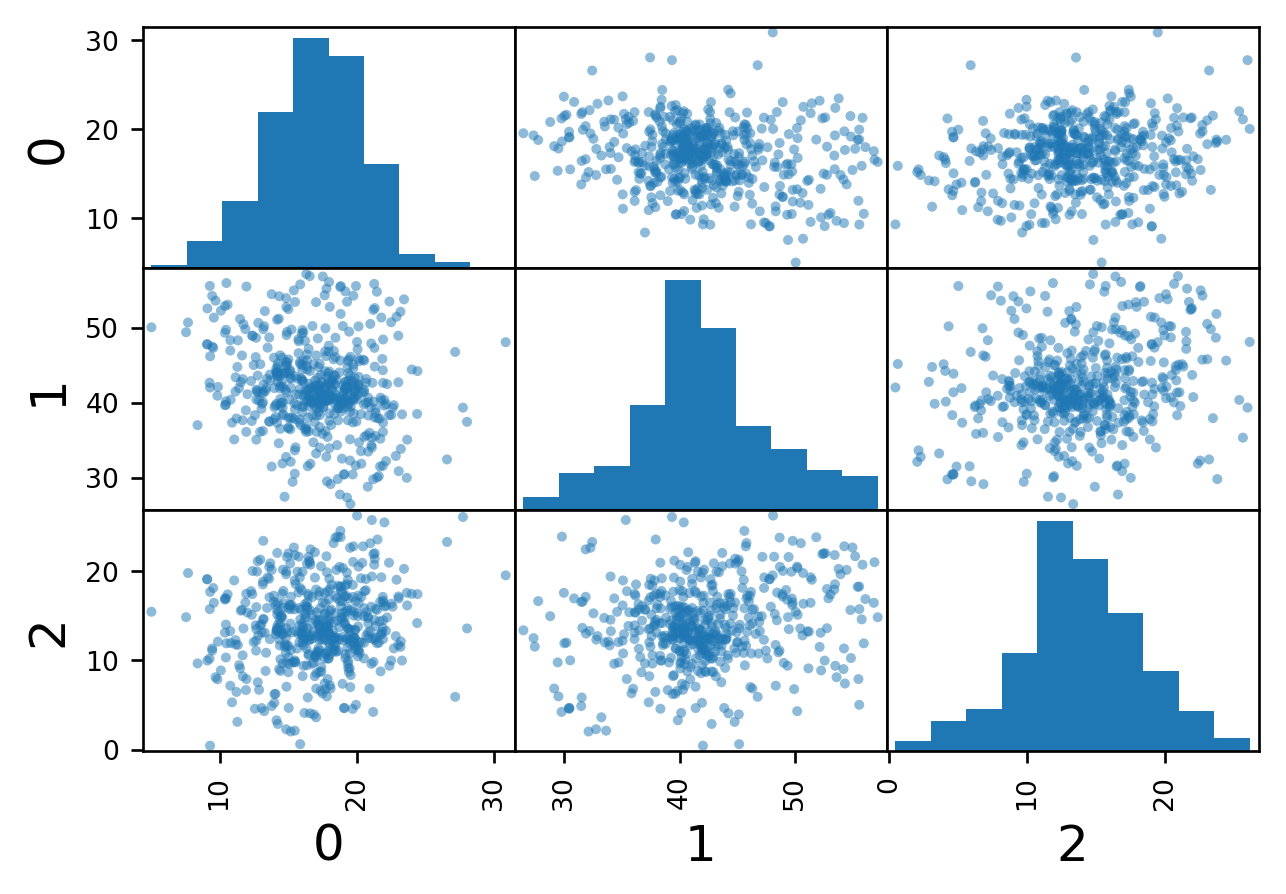

In [144]:
pd.plotting.scatter_matrix(pd.DataFrame(hy_dr2_coords.cartesian.xyz.value.T));

In [315]:
b0=[0,0,0]
Rmax = 10
N = 500
tmp = np.random.normal(size=(3,N))
xyz = np.random.uniform(size=(3, N))**(1./3.)*Rmax / np.linalg.norm(tmp, axis=0)*tmp
xyz_coords = coord.ICRS(*xyz*u.pc, representation_type='cartesian')

In [316]:
mockhy = kinesis.Cluster([0,0,0], 0.3, omegas=[0,0.05,0],
                         ws=[0, 0, 0, 0, 0],
                         b0=b0)
mockhy_members = mockhy.sample_at(xyz_coords)
mockhy_members_pmra = mockhy_members.spherical.differentials['s'].d_lon.to(u.mas/u.yr).value
mockhy_members_pmdec = mockhy_members.spherical.differentials['s'].d_lat.to(u.mas/u.yr).value

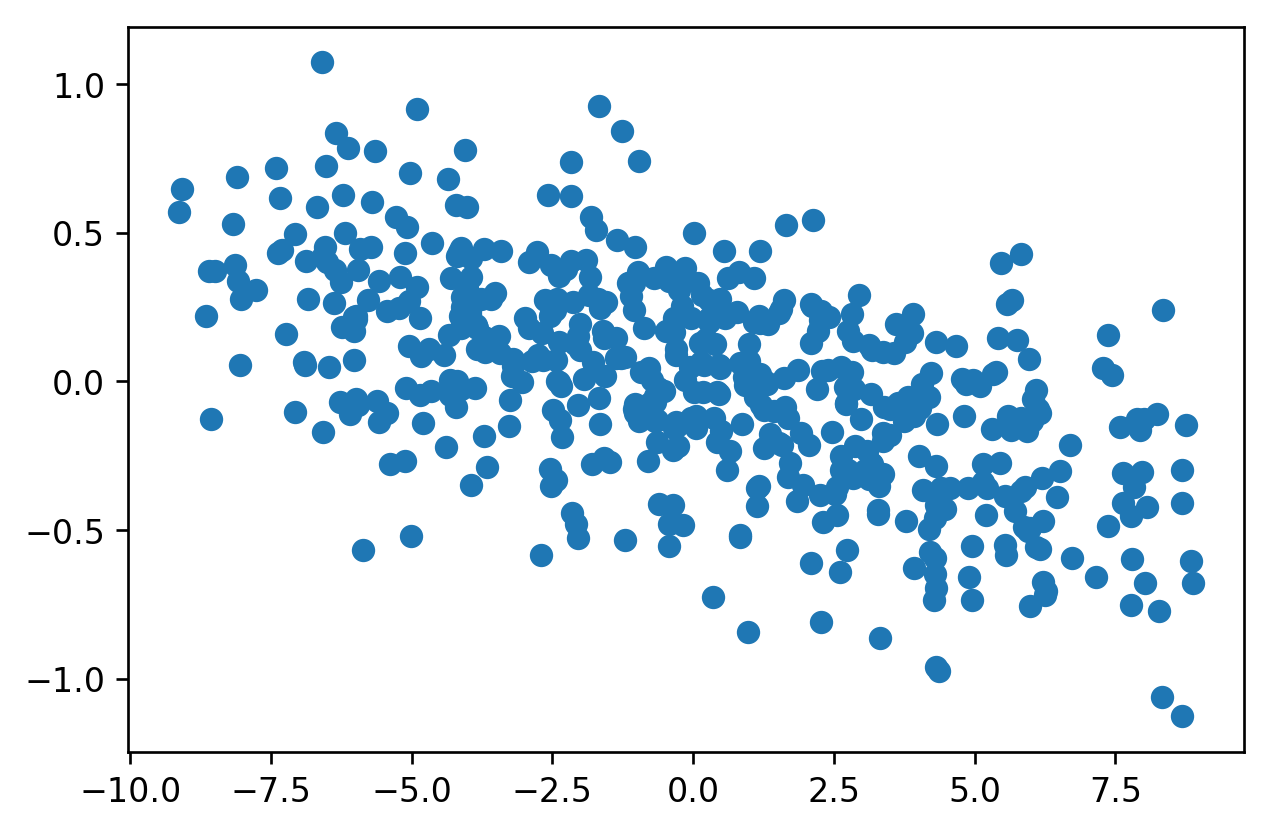

In [317]:
plt.scatter(mockhy_members.x, mockhy_members.v_z)

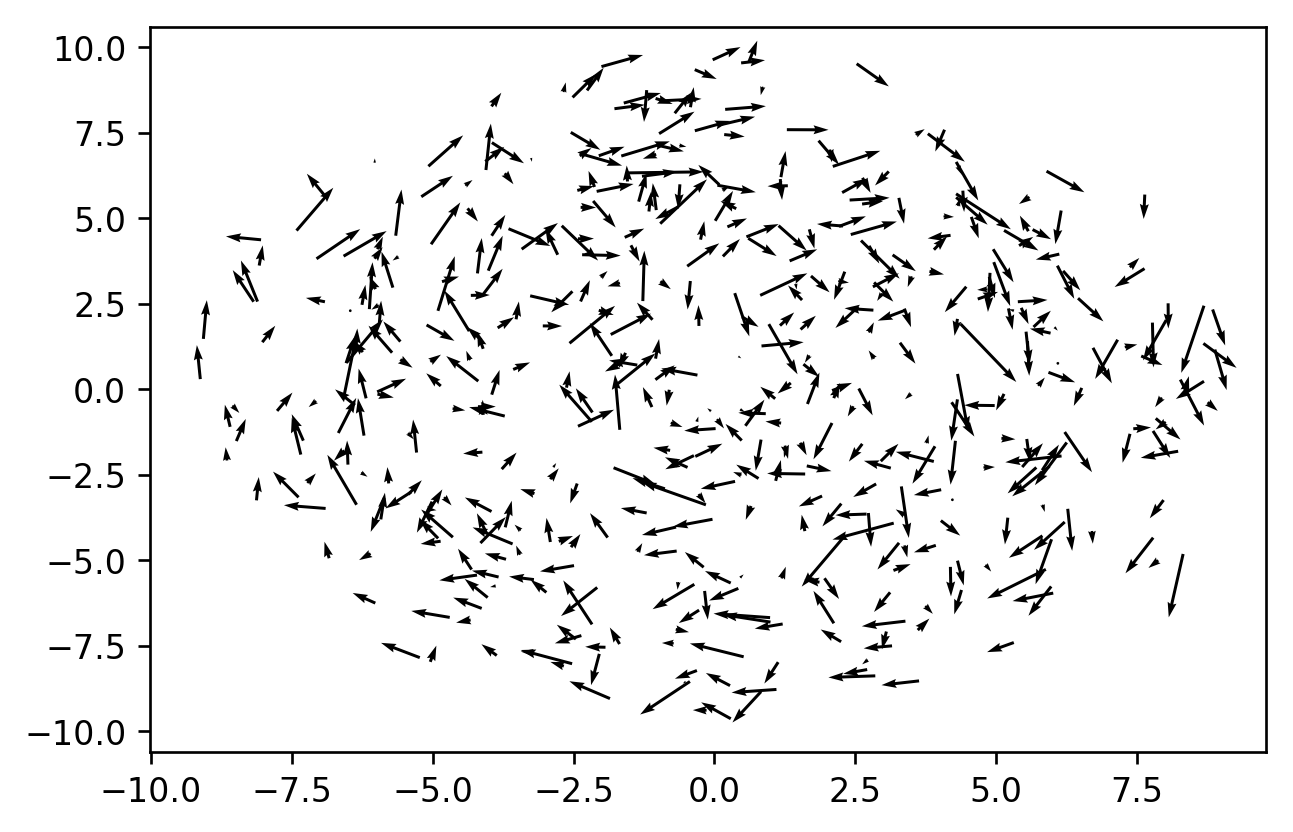

In [323]:
slc = np.fabs(mockhy_members.y.value)<10
plt.quiver(mockhy_members.x[slc], mockhy_members.z[slc],
           mockhy_members.v_x[slc], mockhy_members.v_z[slc])